# Preference Update Bandit

In [1]:
# Import modules.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
%matplotlib inline
import import_ipynb
from abstract_bandit import Bandit

importing Jupyter notebook from abstract_bandit.ipynb


In [2]:
class PrefBandit(Bandit):

    def __init__(self, means, sigmas, arms=10, iters=10000, alpha=None, deterministic=False, stationary=True):
        """Initializes the Upper Confidence Bound bandit."""
        super().__init__(means, sigmas, arms=arms, iters=iters, deterministic=deterministic, stationary=stationary)
        # Step size for update.
        self.alpha = alpha
        # Preference values of actions.
        self.prefs = np.zeros(arms)
        # Probability of choosing action.
        self.probs = np.full(arms, 1.0 / float(arms))
        # Matrix to store the trend of the preferences.
        self.Hs = np.zeros((iters + 1, arms))

    def choose_action(self):
        """Implements the epsilon-greedy policy: exploits knowledge or explores new possibilities."""
        return np.random.choice(list(range(self.arms)), p=self.probs)

    def update_model(self, arm, reward, iteration):
        """Updates estimates and other data after an episode."""
        # Update choice count.
        self.Ns[arm] += 1
        # Update step size.
        if self.alpha == None:
            step_size = 0.1 / float(self.Ns[arm])
        else:
            step_size = self.alpha
        # Update average reward (note that now this has to be done here!).
        self.avg_rewards[iteration + 1] = self.avg_rewards[iteration] + (1.0 / float(iteration + 1)) * (reward - self.avg_rewards[iteration])
        # Update preferences.
        for i in range(arms):
            if i == arm:
                self.prefs[i] += step_size * (reward - self.avg_rewards[iteration + 1]) * (1.0 - self.probs[i])
            else:
                self.prefs[i] -= step_size * (reward - self.avg_rewards[iteration + 1]) * self.probs[i]
        # Update actions probabilities.
        exp_sum = np.sum(np.exp(self.prefs))
        self.probs = np.exp(self.prefs) / exp_sum
        # Eventually increase optimal actions counter.
        if arm == np.argmax(self.means):
            self.opt_actions += 1.0
        # Update real action values.
        if self.stationary == False:
            for i in range(self.arms):
                self.means[i] += self.means_rng.standard_normal()

    def update_sim_data(self, arm , reward, iteration):
        """Updates simulation data after an episode."""
        self.Hs[iteration + 1, :] = self.prefs
        self.qs[iteration + 1, :] = self.means

    def get_prefs(self):
        """Returns actions preferences."""
        return np.copy(self.Hs)

def pref_plots(iters, arms, means, sigmas, alphas, det, stat):
    """Function that generates test plots for this Bandit."""
    # Simulation data arrays.
    rews = np.zeros((len(alphas), iters + 1))
    actions = np.zeros((len(alphas), arms))
    optimals = np.zeros((len(alphas), 1))
    Hs_list = []

    # Bandits execution.
    for i in range(len(alphas)):
        bandit = PrefBandit(np.copy(means), sigmas, arms=arms, iters=iters, alpha=alphas[i], deterministic=det, stationary=stat)
        bandit.run()
        rews[i, :] = bandit.get_avg_rewards()
        actions[i, :] = bandit.get_actions()
        optimals[i, 0] = bandit.get_opt_actions()
        Hs_list.append(bandit.get_prefs())
    
    for i in range(len(alphas)):
        fig = plt.figure(figsize=(20,40))
        plt.subplots_adjust(top=0.95)
        fig.suptitle(r'$\alpha$ = ' + str(alphas[i]))
        gs = gridspec.GridSpec(1+arms, 2, figure=fig)
        # Average rewards plot.
        ax1 = plt.subplot(gs[0, 0])
        ax1.plot(rews[i, :], color='b')
        ax1.set(xlabel='Iterations', ylabel='Avg. rewards')
        ax1.set_title('Average rewards')
        # Actions taken plot
        ax2 = plt.subplot(gs[0, 1])
        x = np.arange(arms)
        ax2.bar(x, actions[i, :])
        ax2.set_yscale('log')
        ax2.set_xticks(x)
        ax2.set_xticklabels(np.arange(1, arms+1))
        ax2.set(xlabel='Actions', ylabel='Number of actions taken')
        ax2.set_title('Actions taken')
        # Real mean vs estimated means subplots
        for k in range(arms):
            ax = plt.subplot(gs[k+1, :])
            ax.set_title("Arm " + str(k+1))
            ax.plot(Hs_list[i][:, k], color='b')

    # Optimal actions frequency heatmap.
    fig, ax = plt.subplots(figsize=(12, 12))
    im = ax.imshow(optimals, cmap='Blues')
    ax.set_xticks([1.0])  # Don't ask.
    ax.set_yticks(np.arange(len(alphas)))
    ax.set_yticklabels(map(str, alphas))
    ax.set_title(r'Percentages of optimal actions taken for each $\alpha$')
    for i in range(len(alphas)):
        text = ax.text(0, i, optimals[i, 0], ha="center", va="center", color='r')

## Deterministic, stationary case

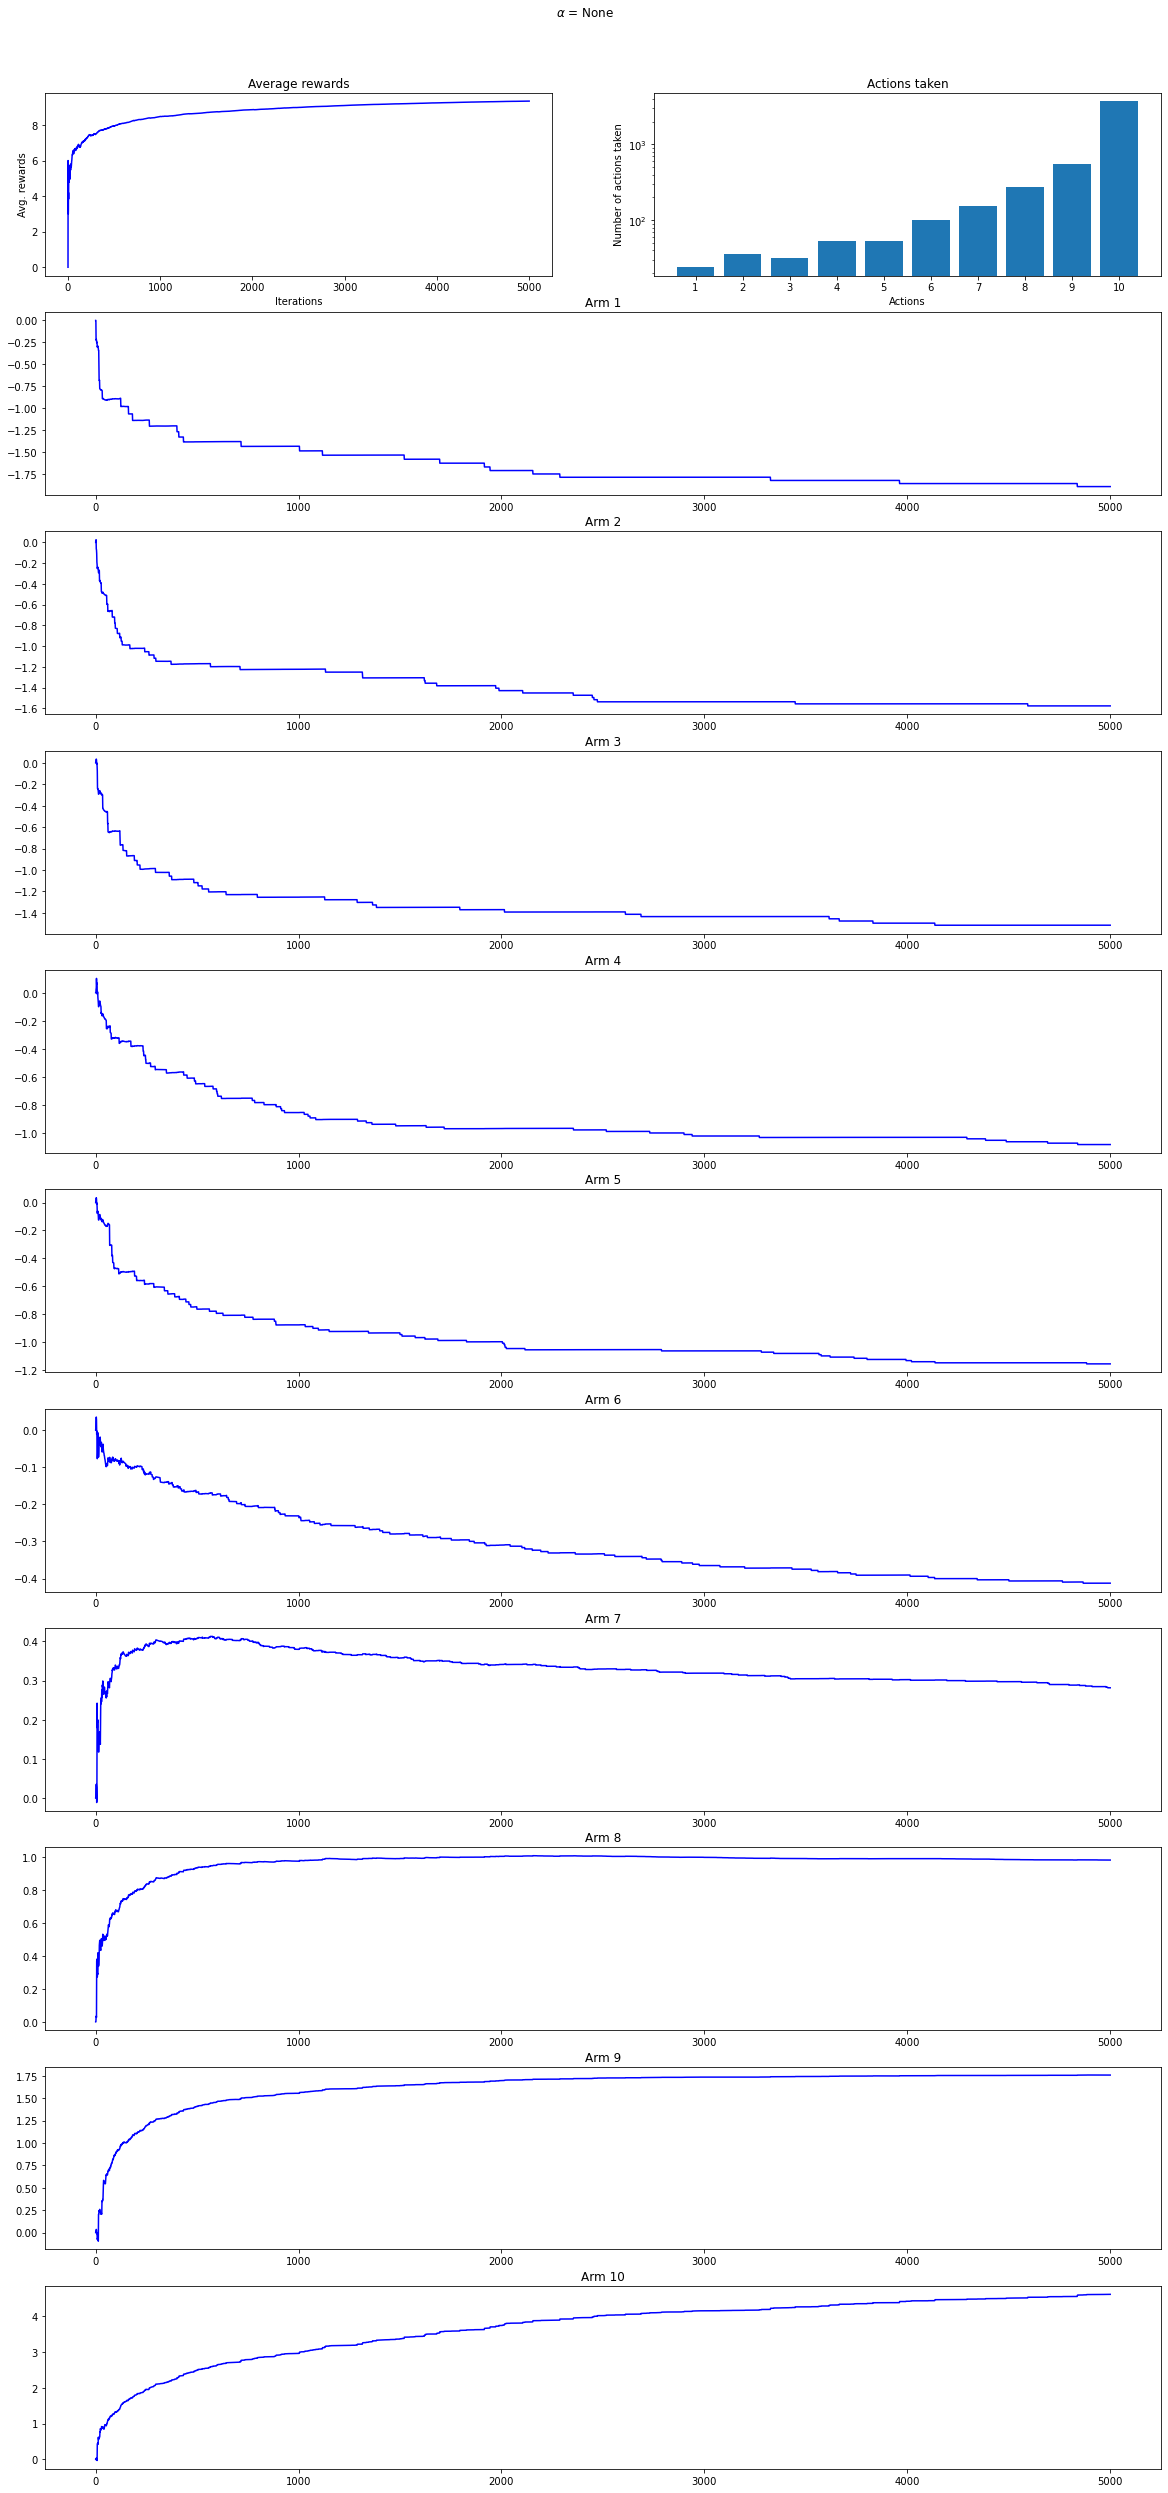

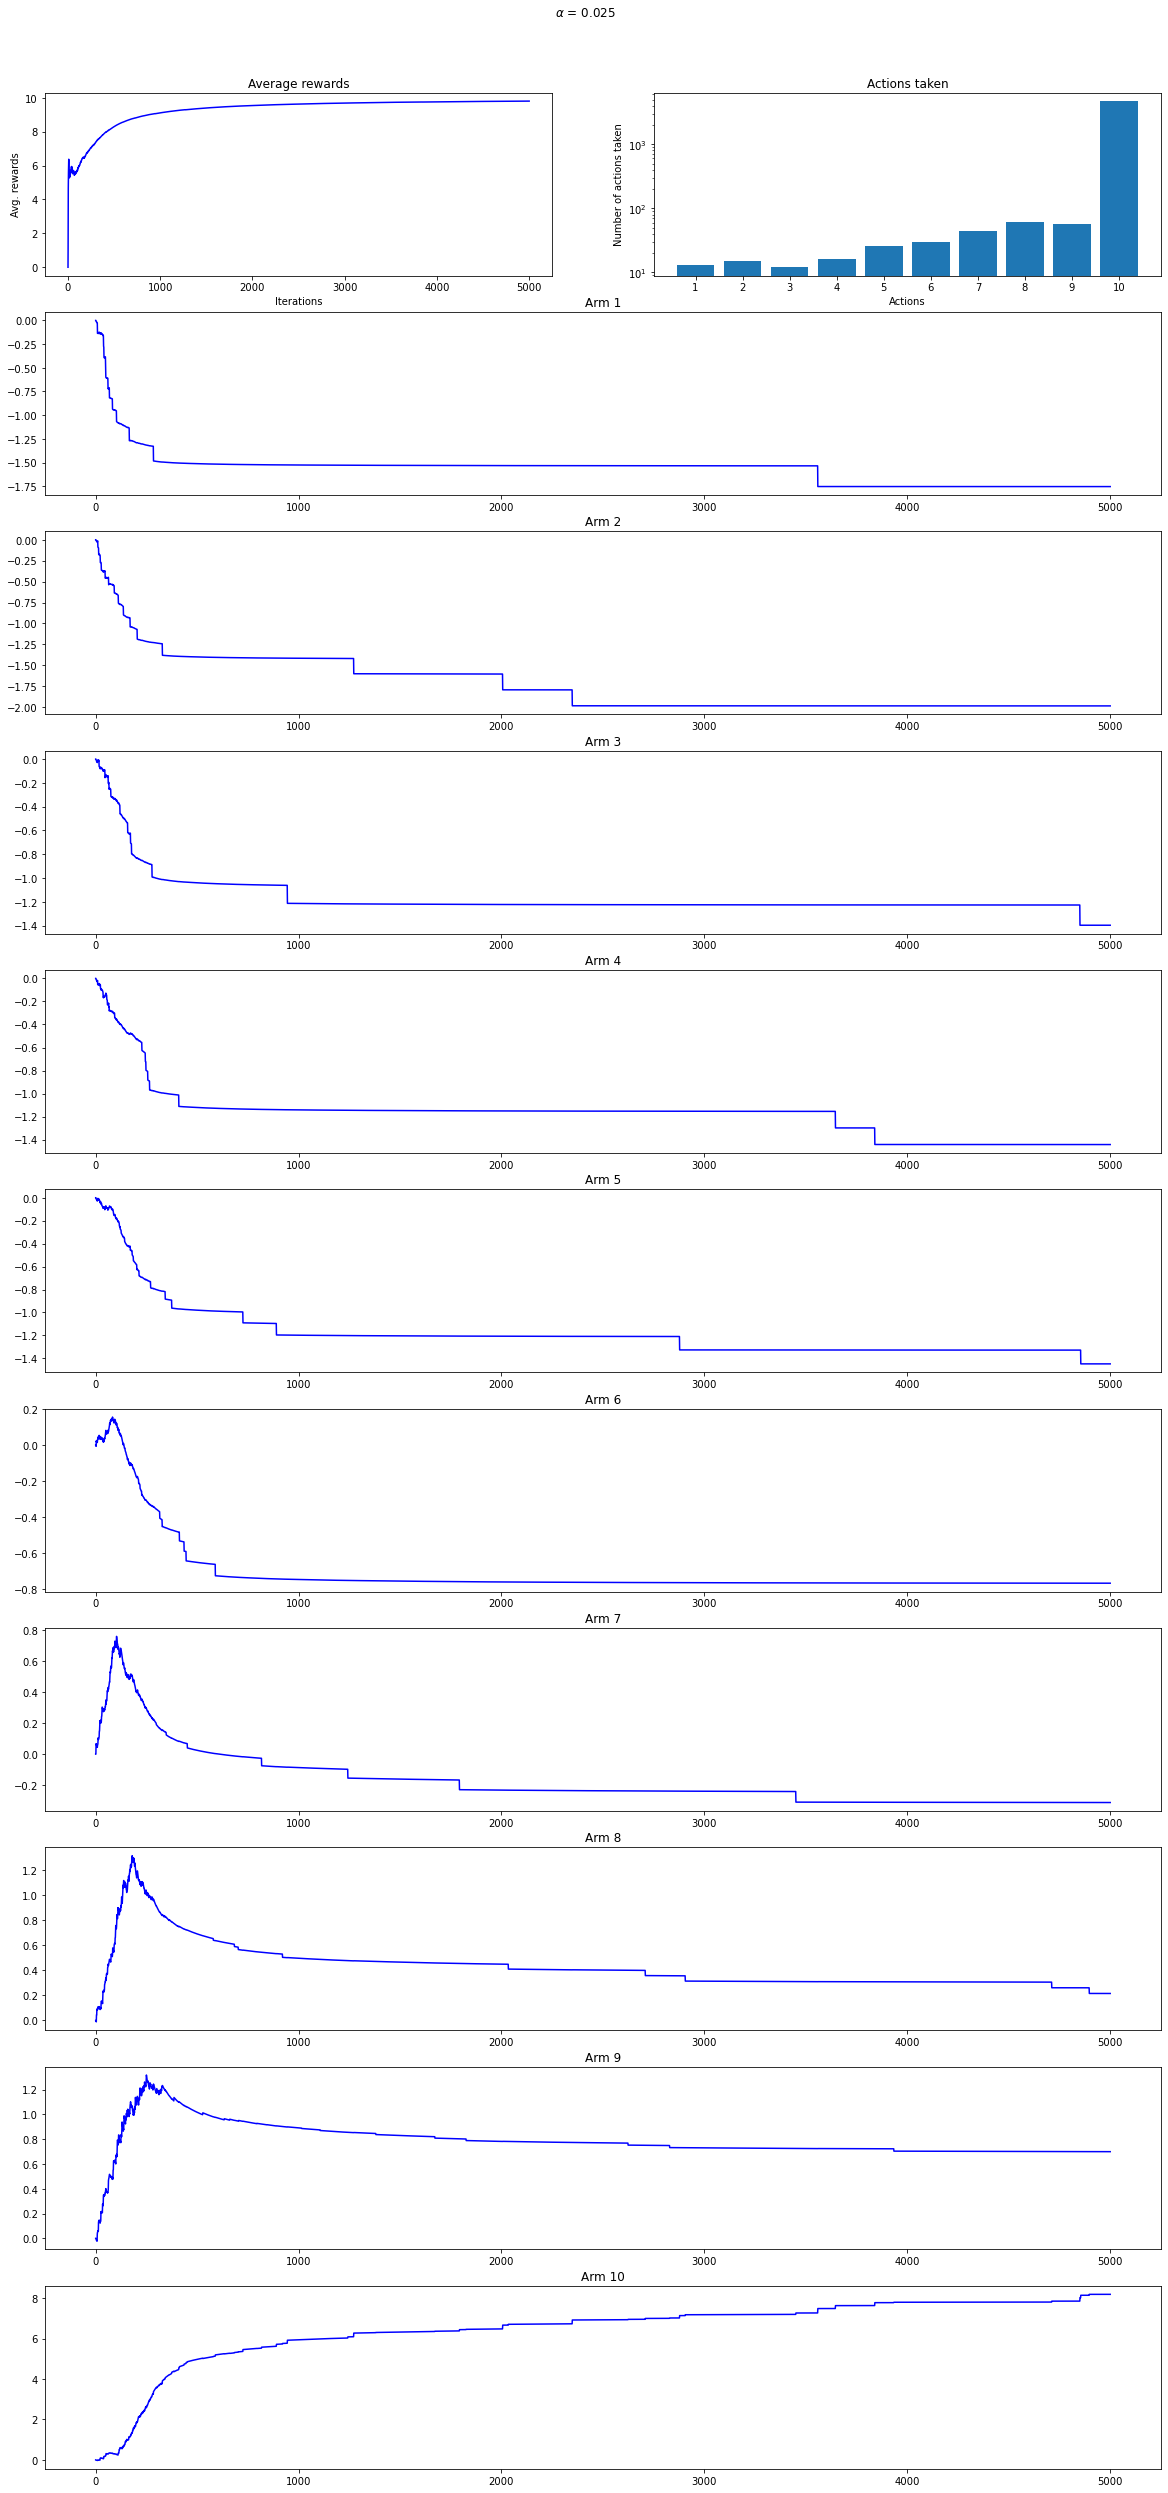

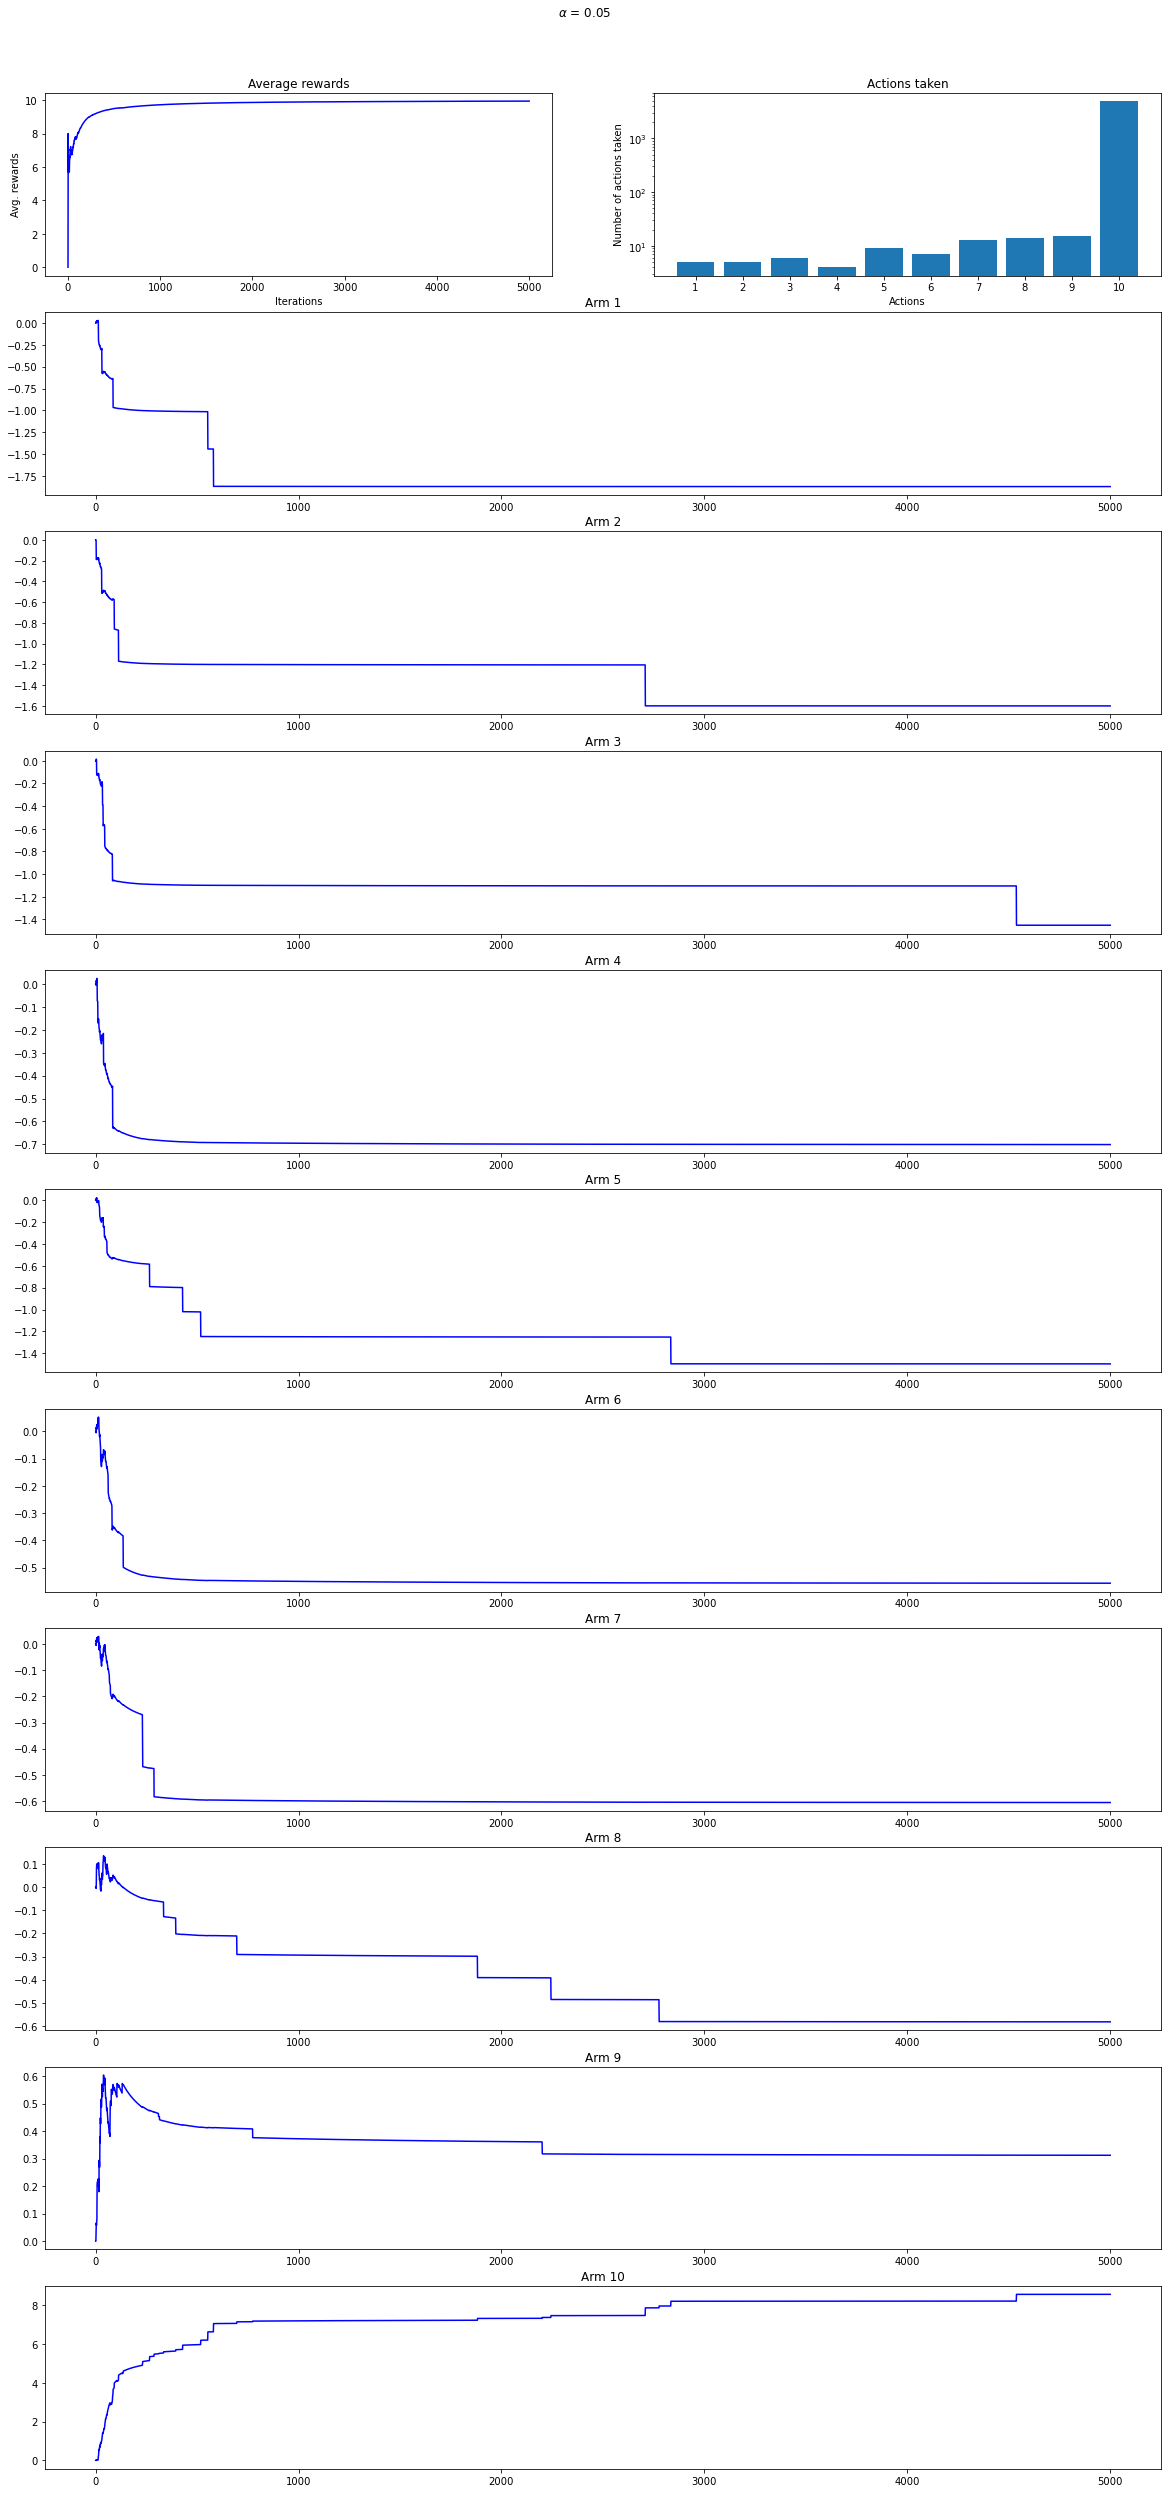

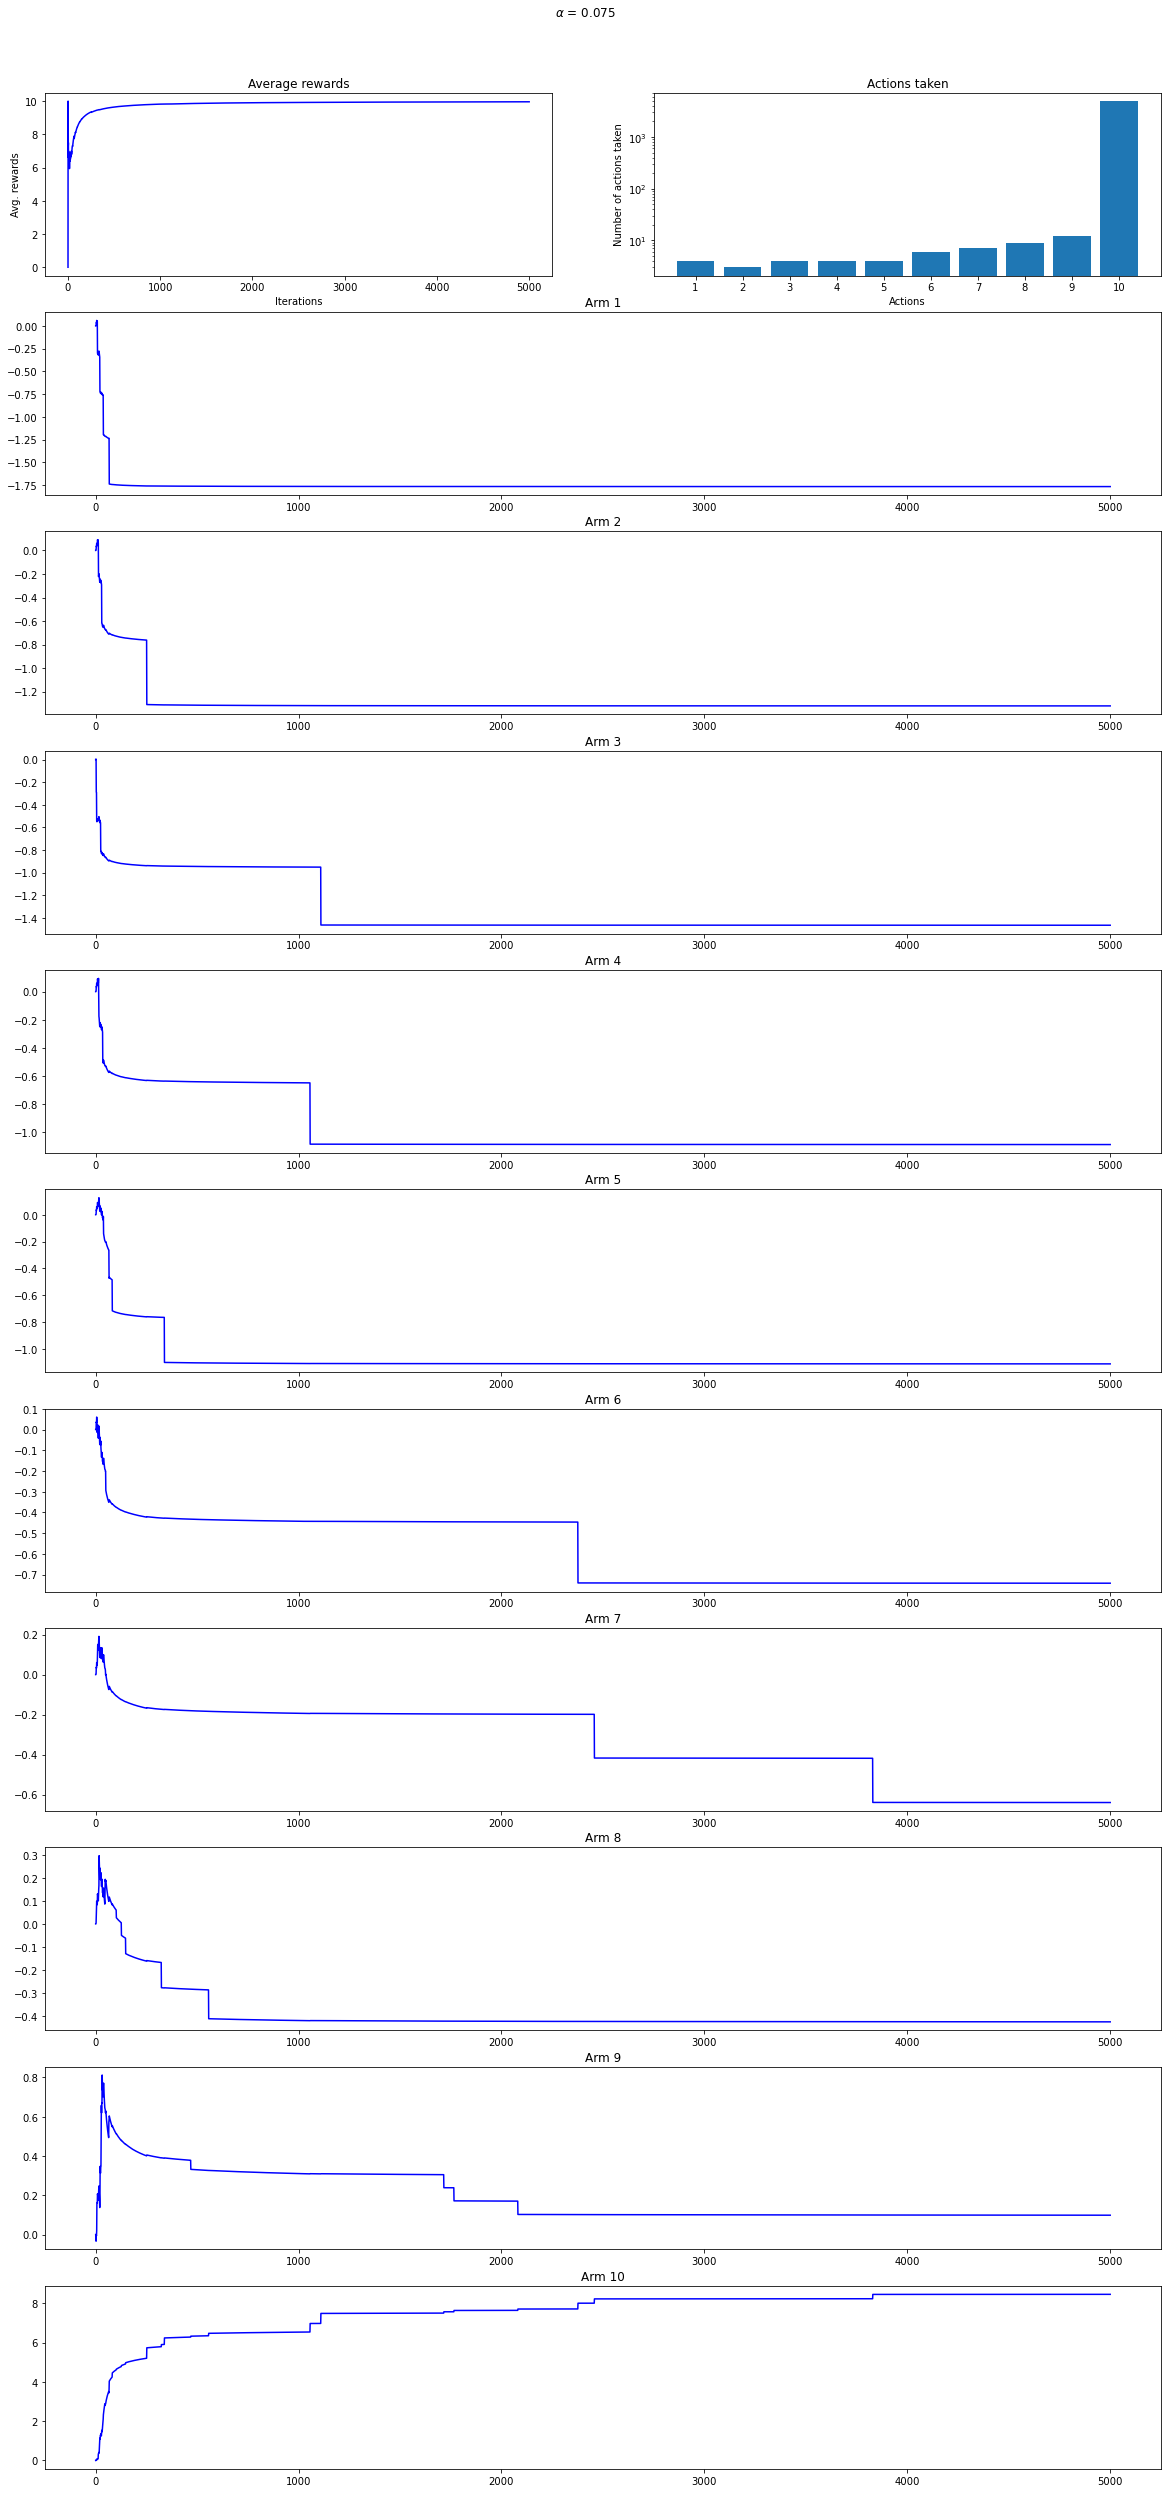

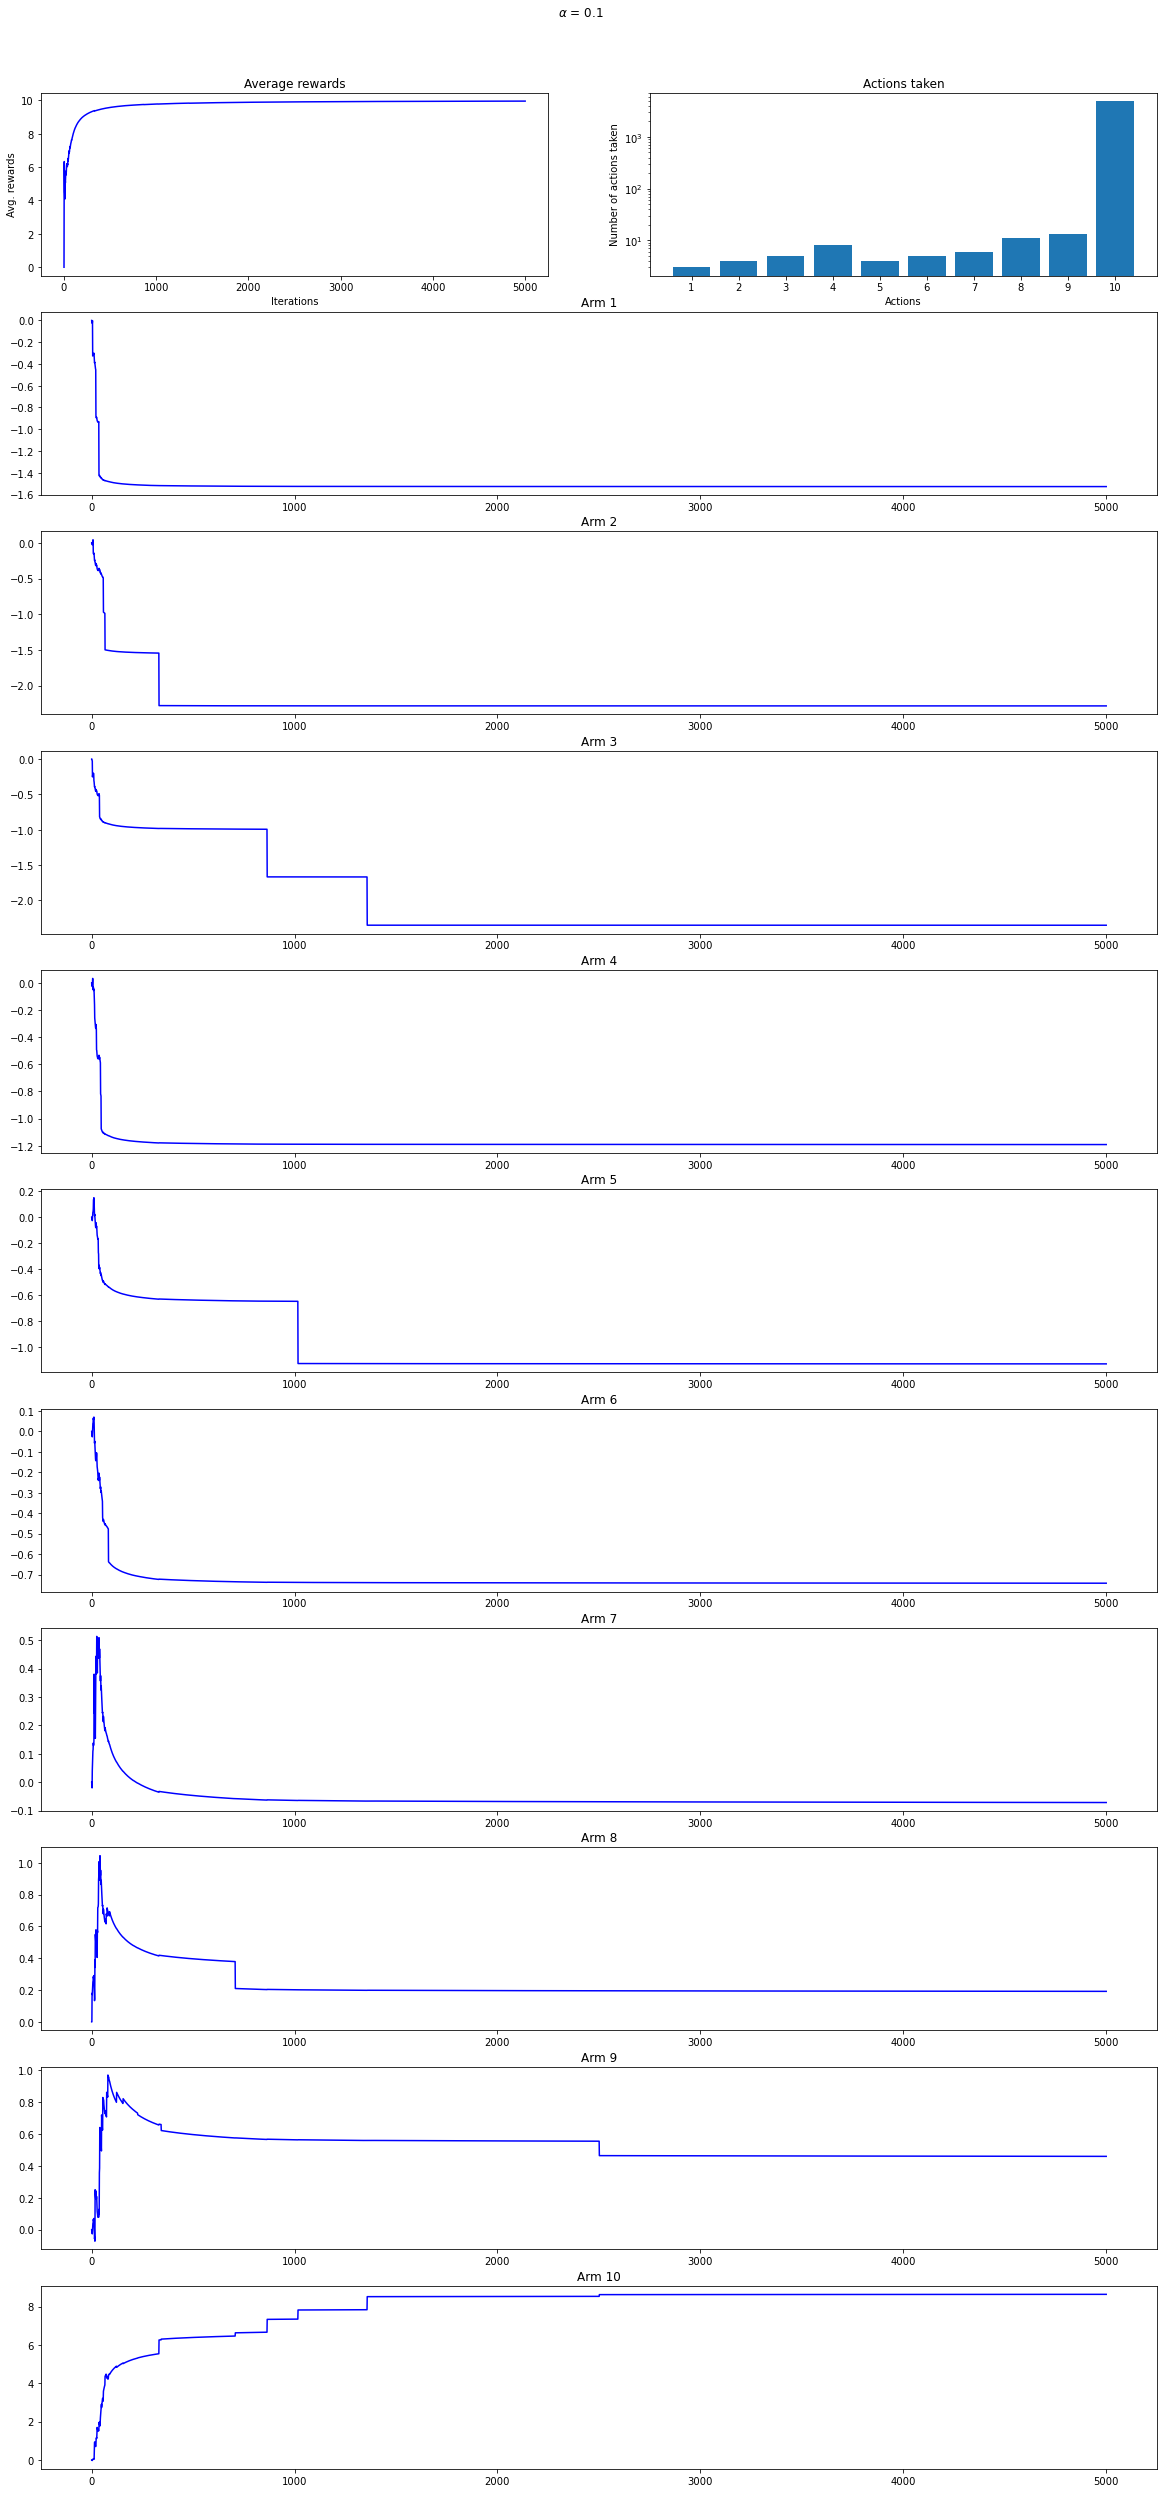

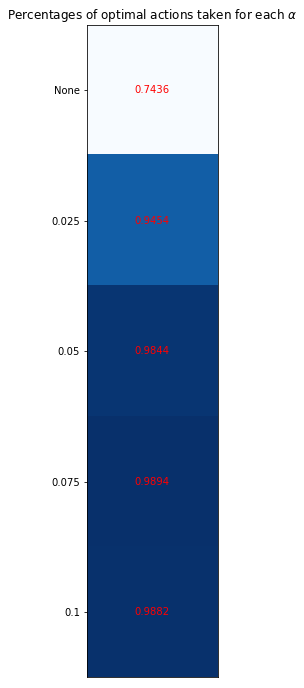

In [3]:
# Simulation parameters (some MUST be floats!).
iters = 5000
arms = 10
means = np.arange(1.0, float(arms + 1), 1.0)
sigmas = None
alphas = [None, 0.025, 0.05, 0.075, 0.1]
det = True
stat = True

pref_plots(iters, arms, means, sigmas, alphas, det, stat)

## Deterministic, non-stationary case

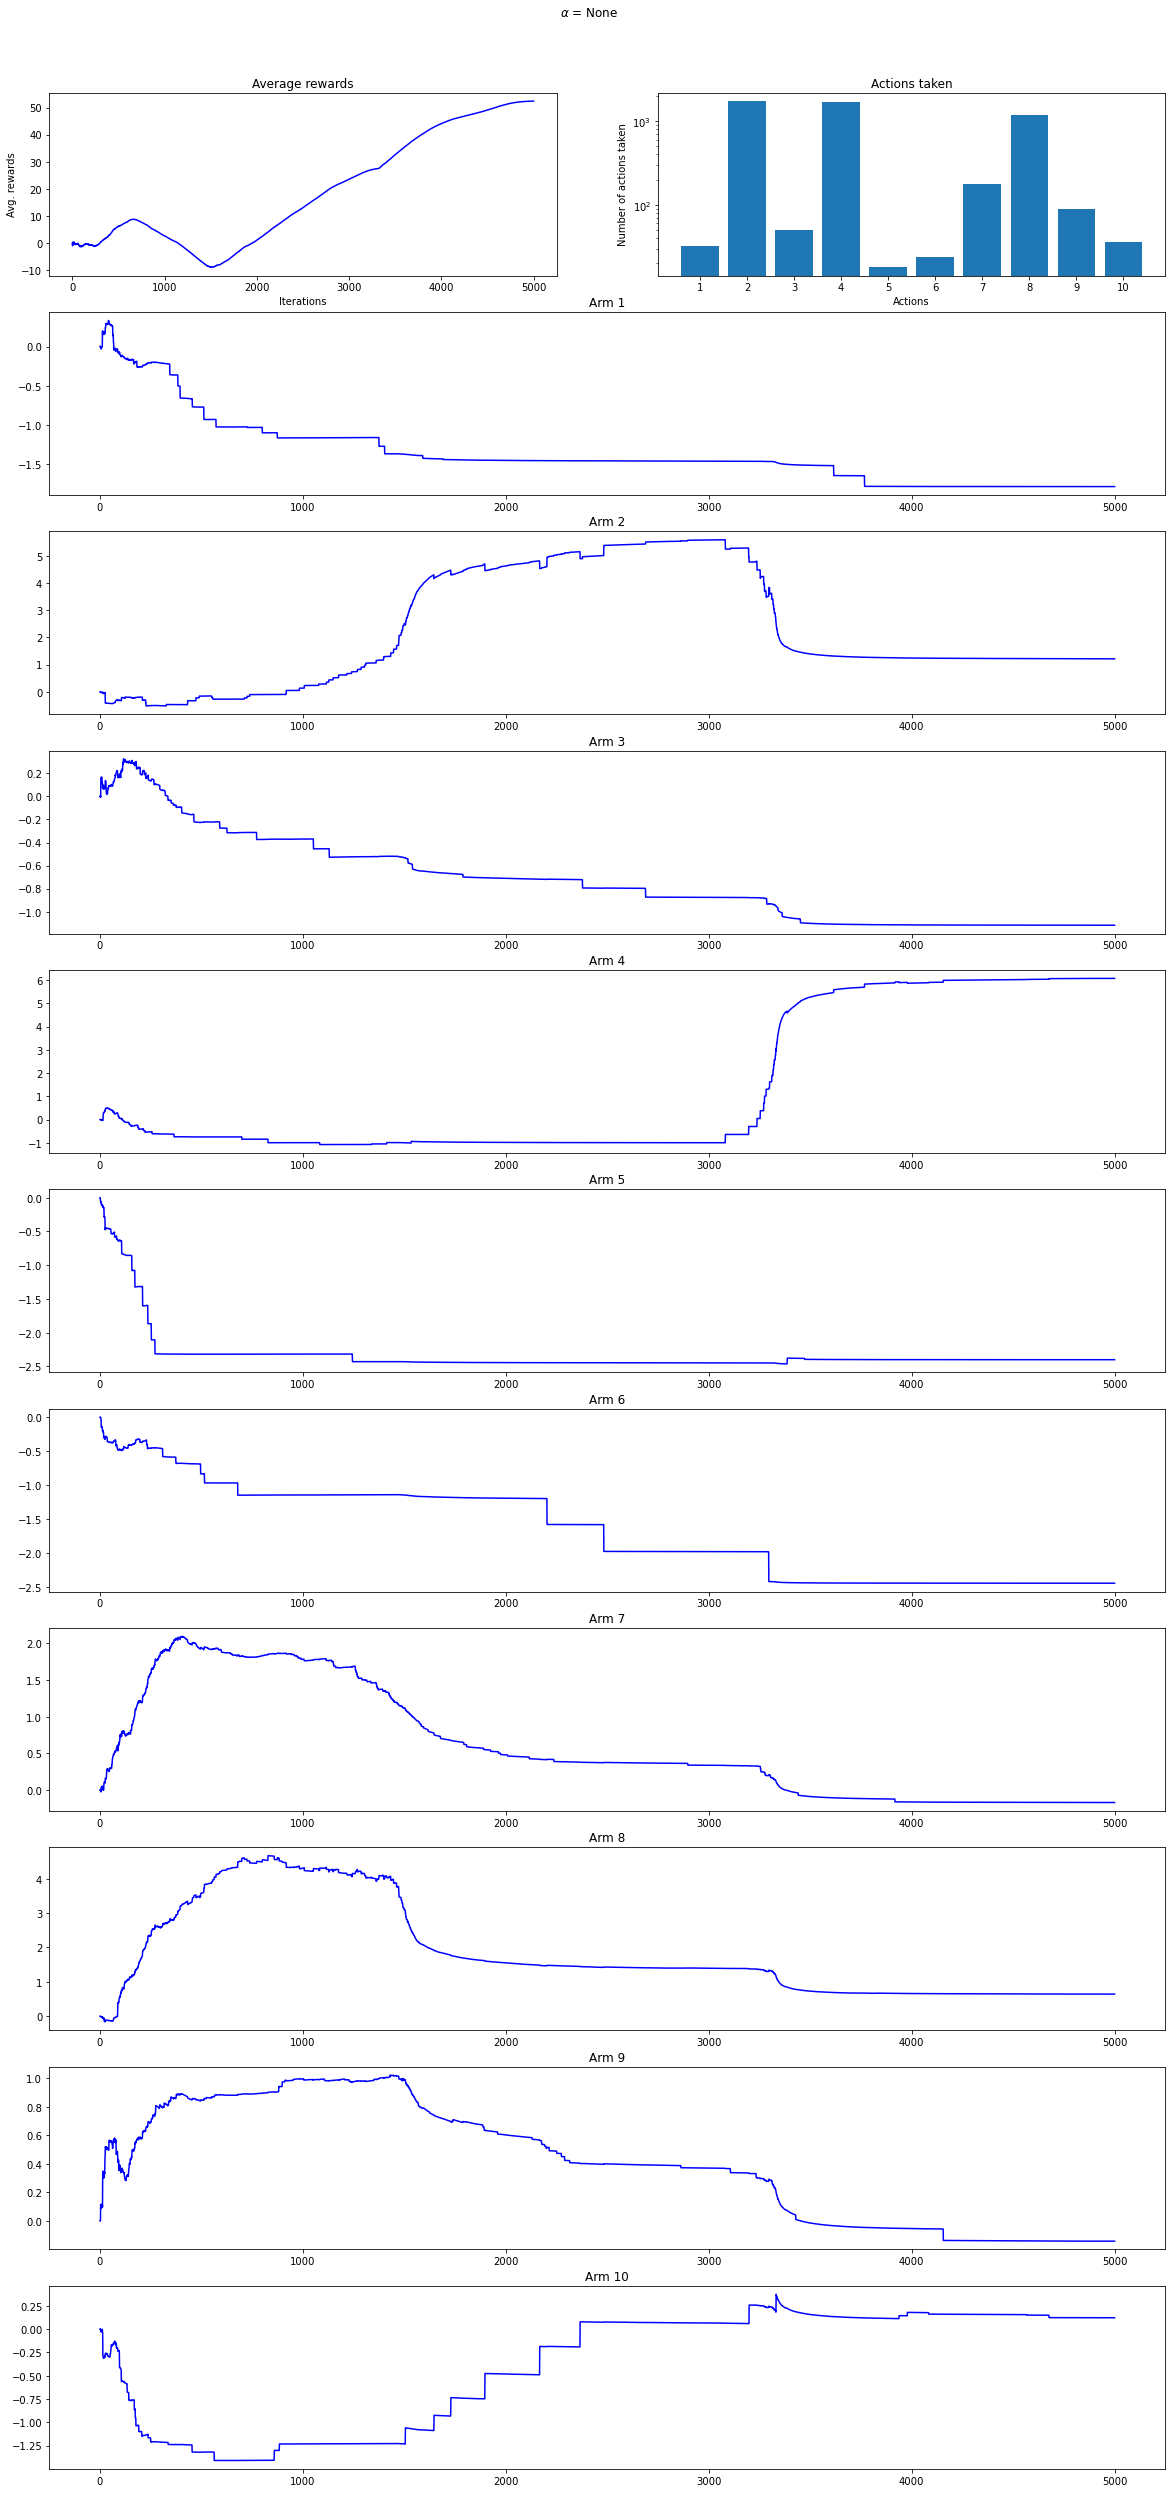

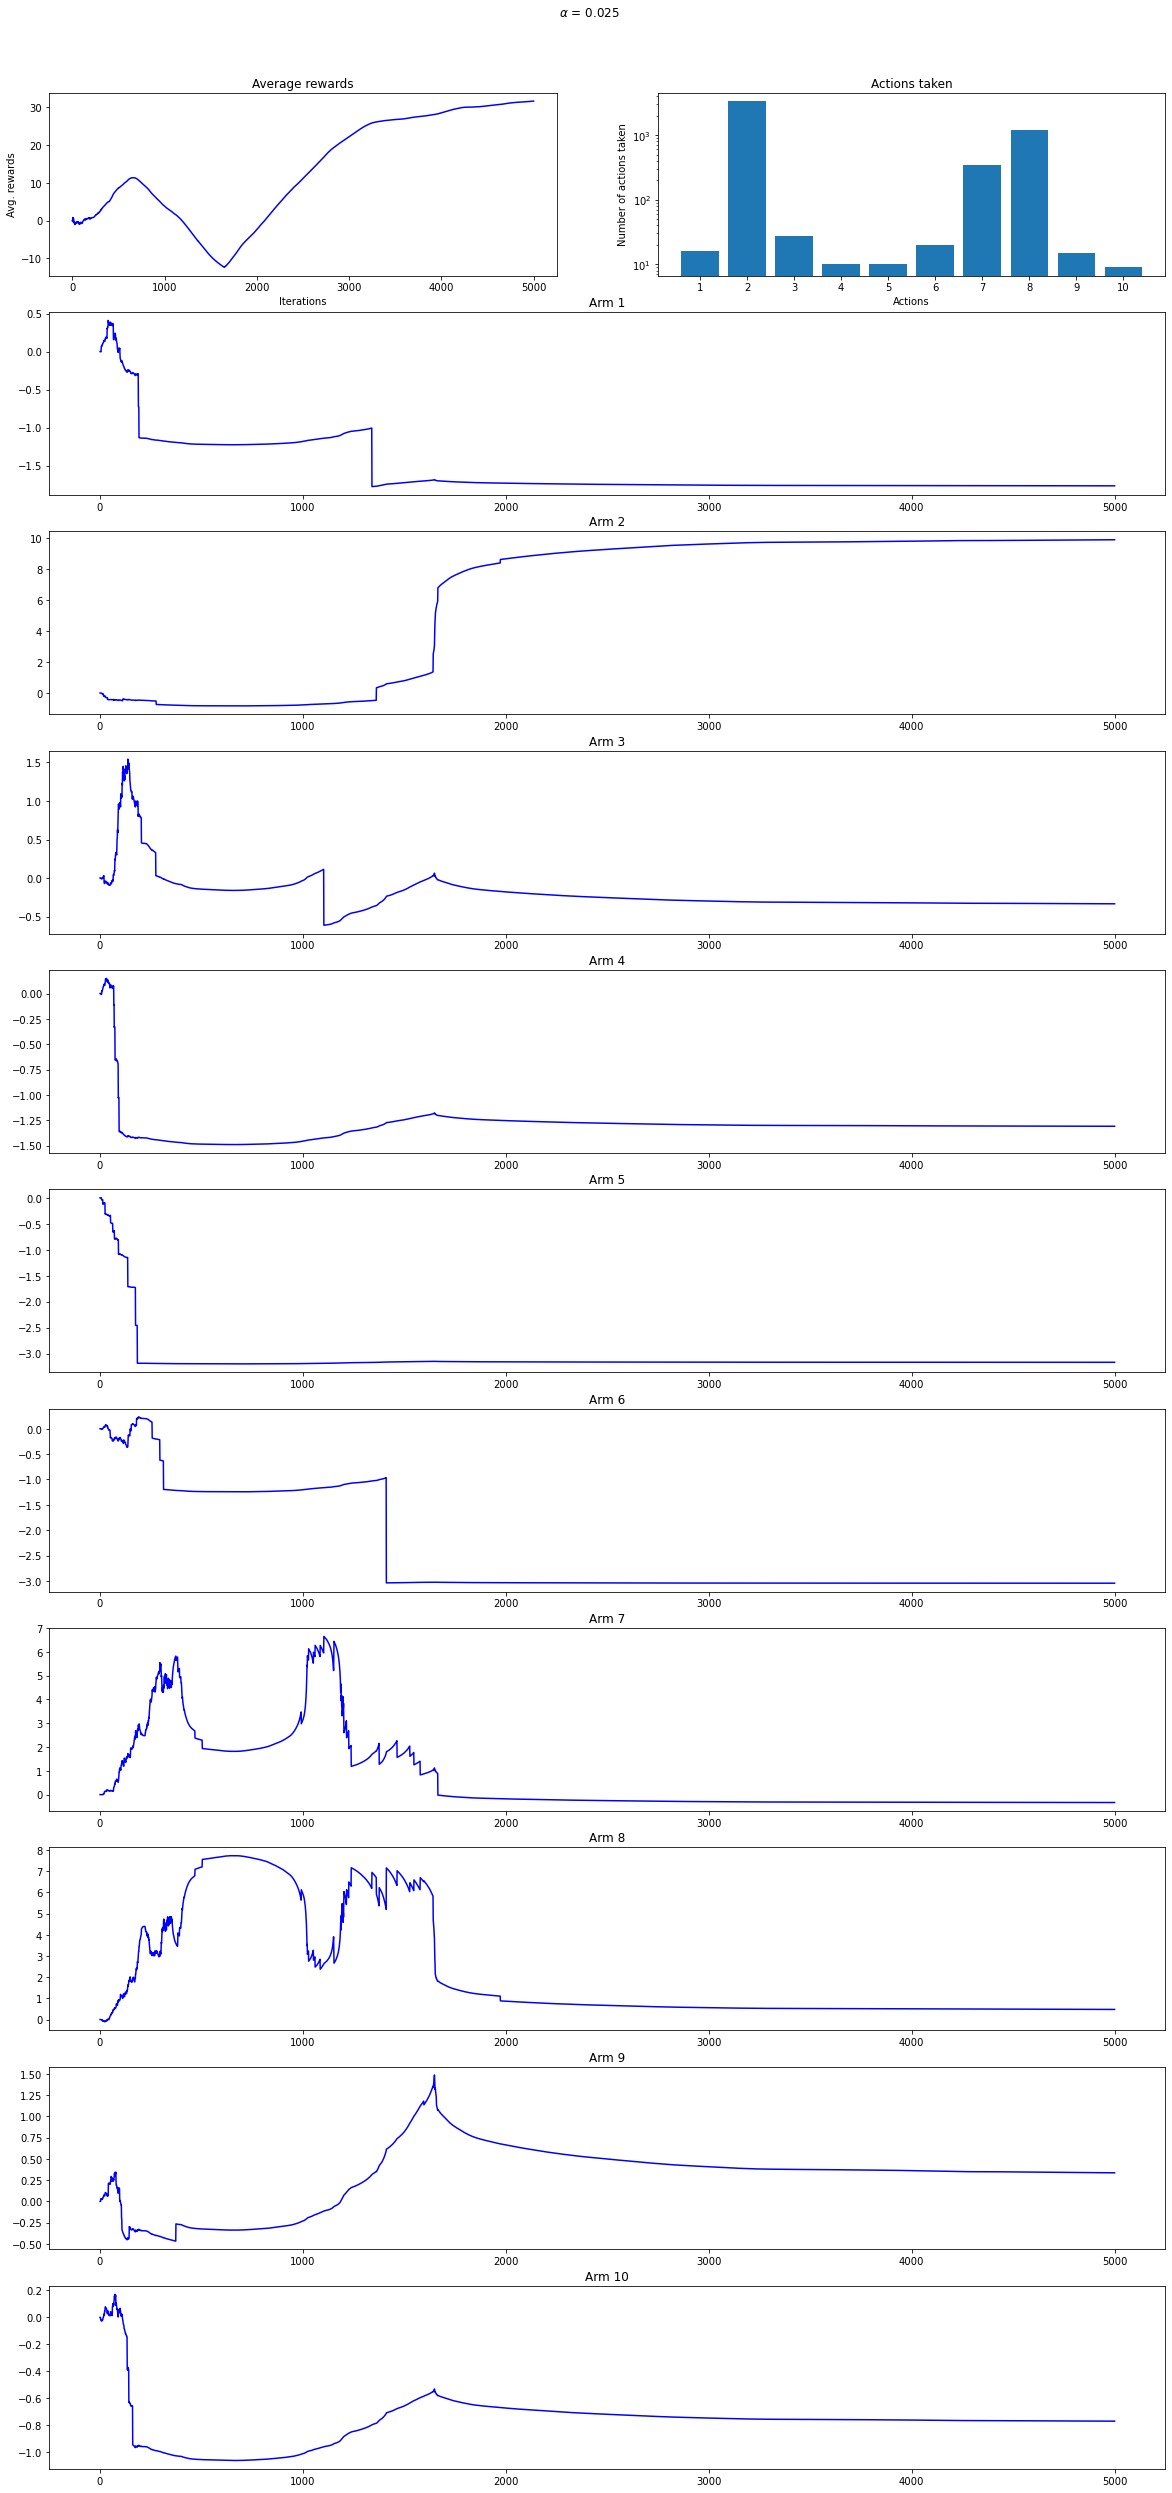

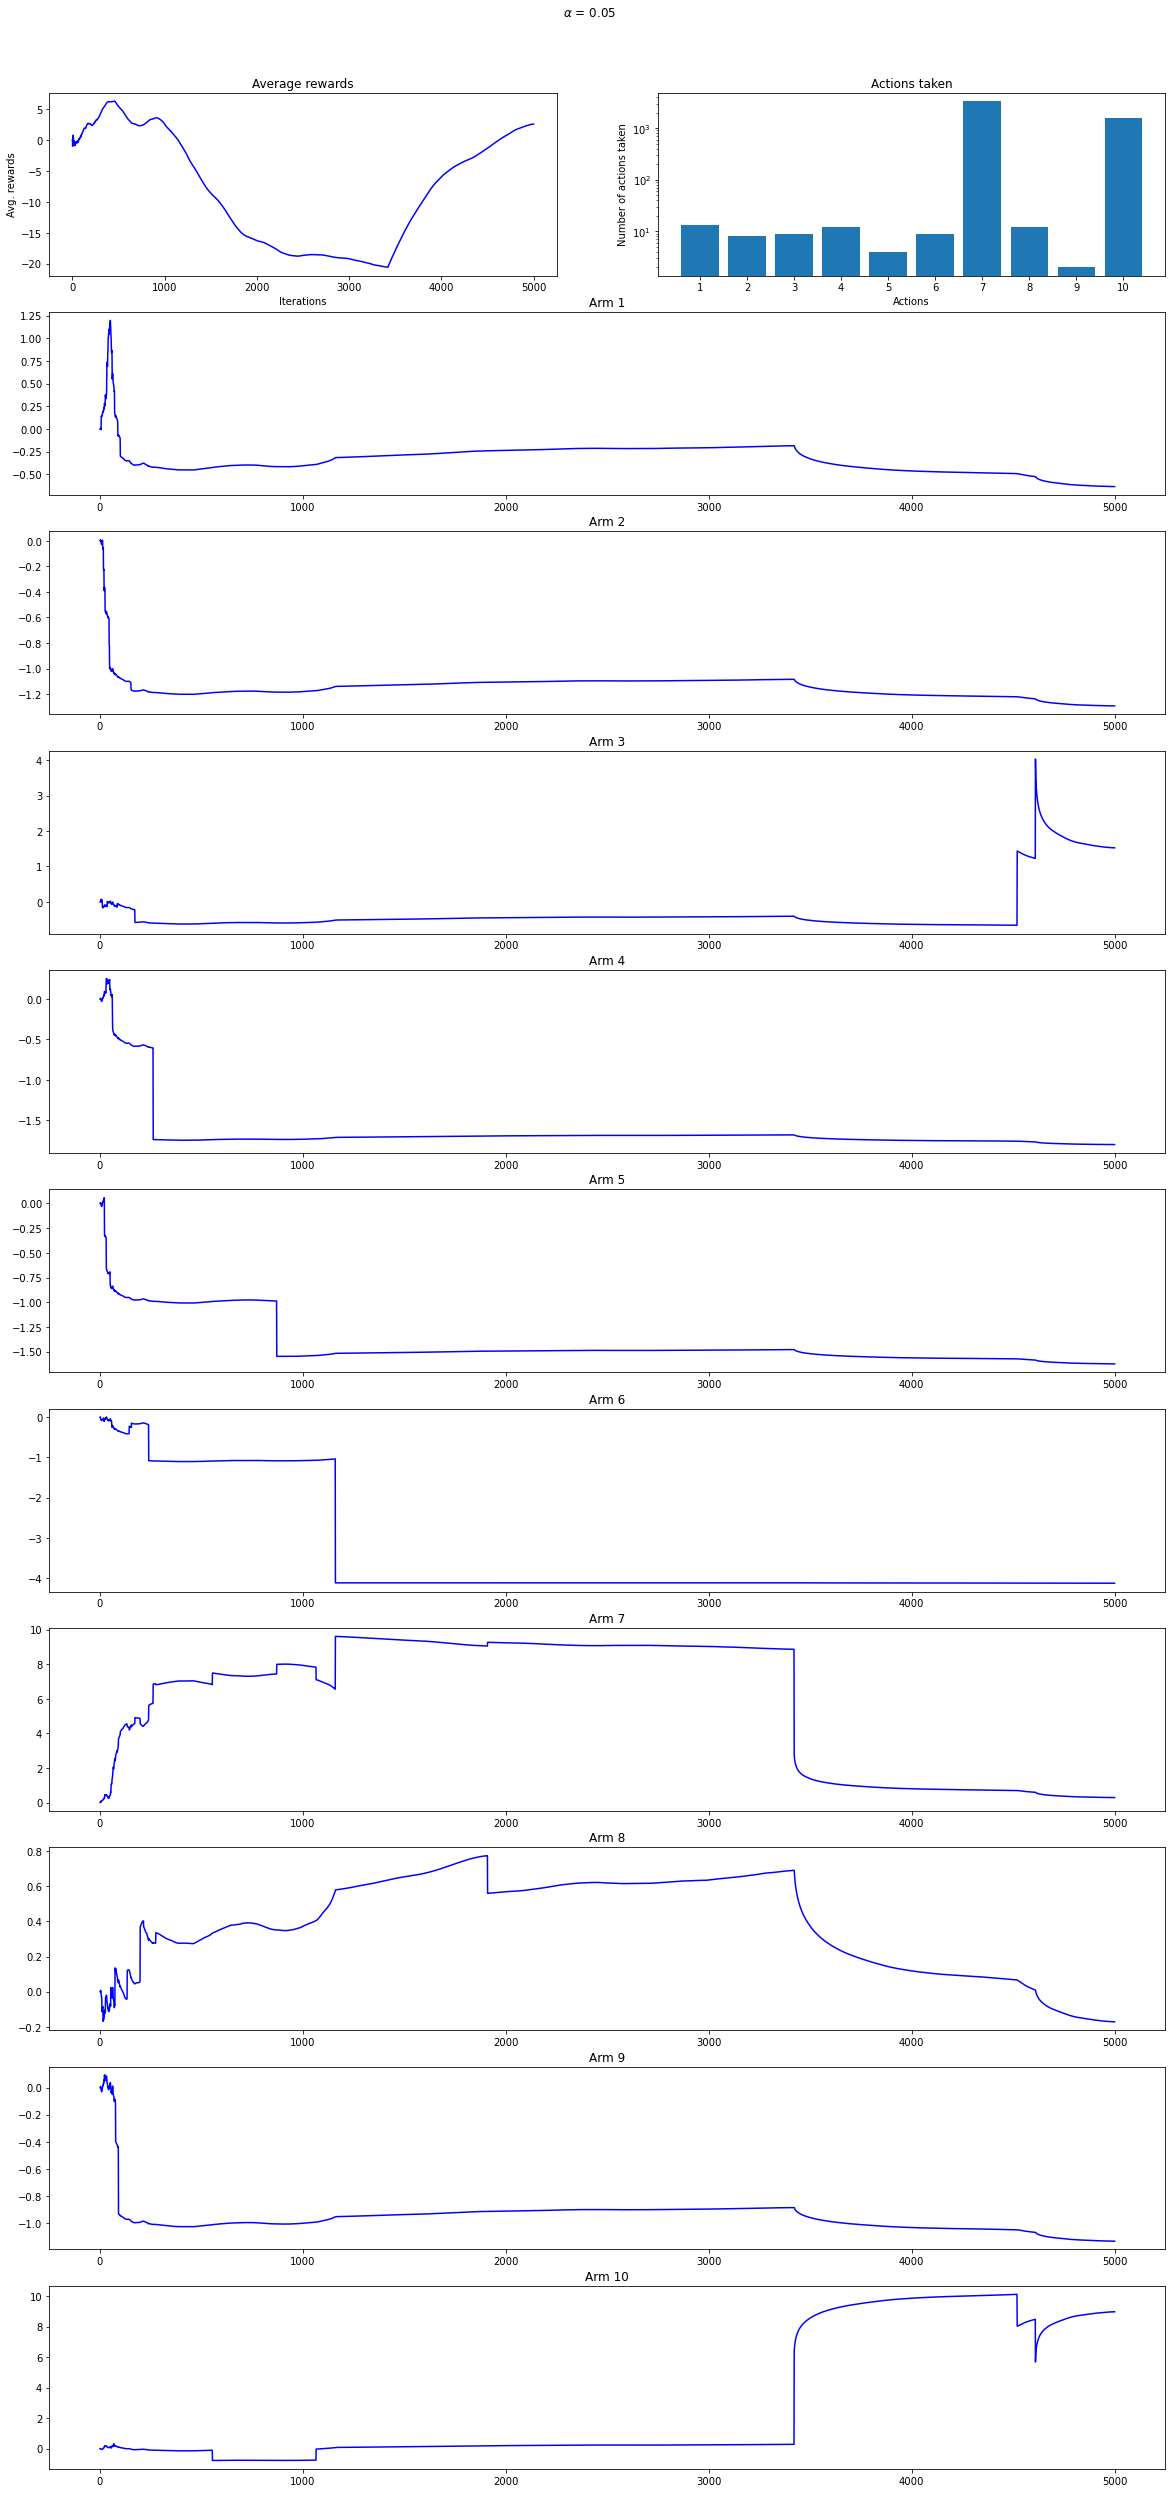

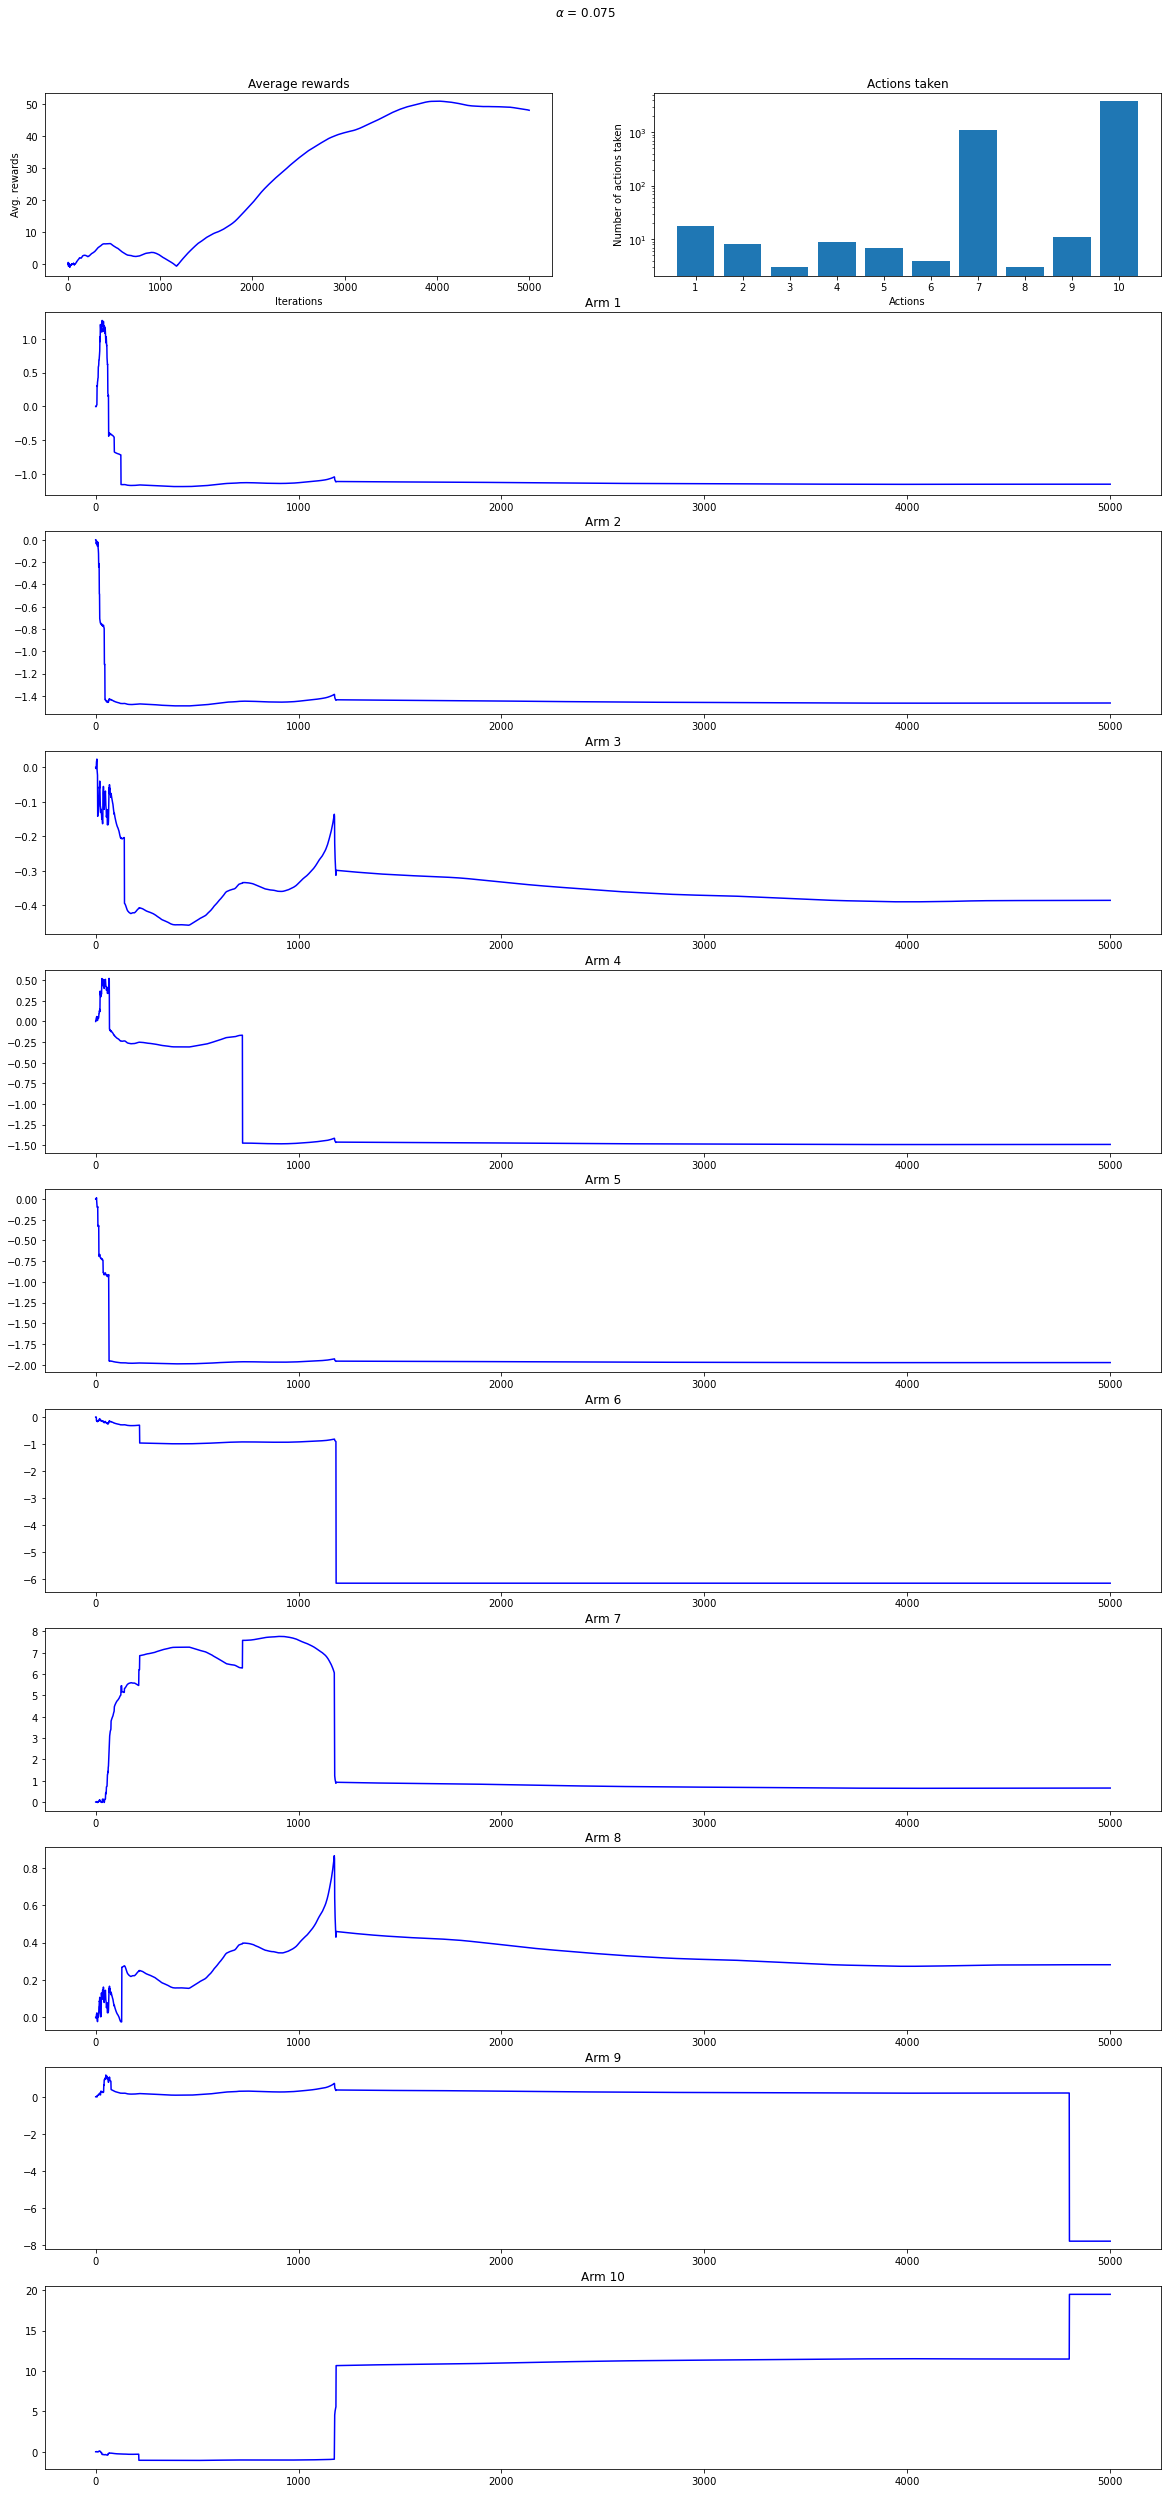

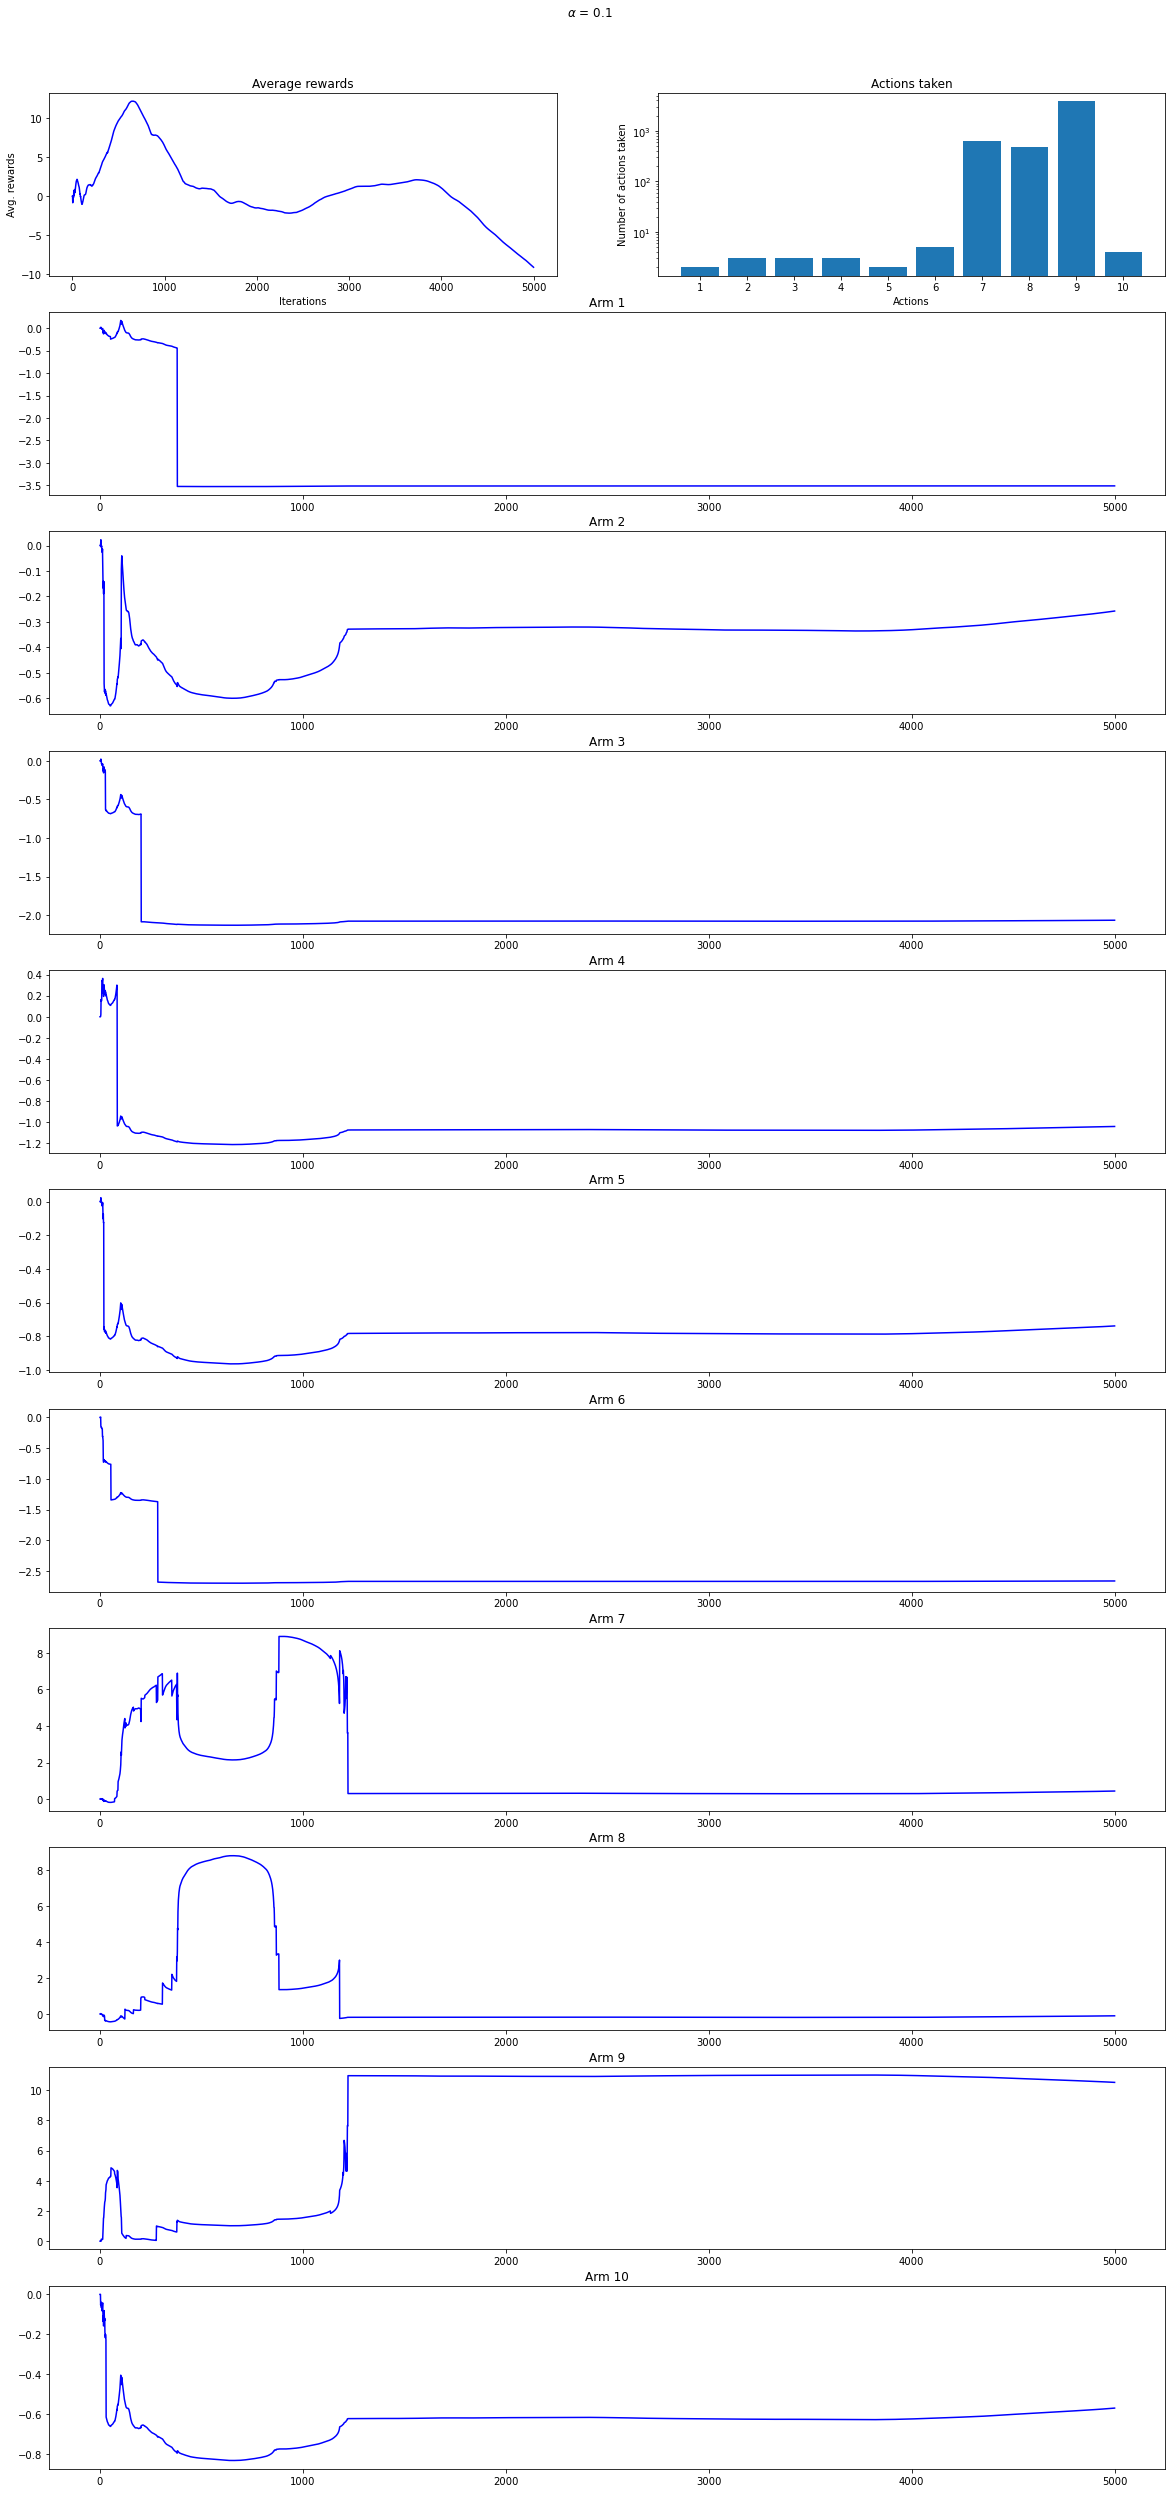

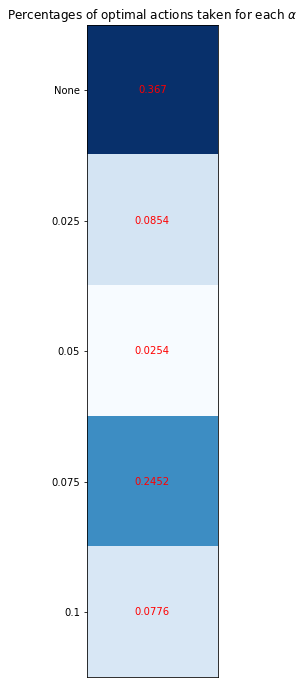

In [4]:
# Simulation parameters (some MUST be floats!).
iters = 5000
arms = 10
means = np.full(arms, 0.0)
sigmas = None
alphas = [None, 0.025, 0.05, 0.075, 0.1]
det = True
stat = False

pref_plots(iters, arms, means, sigmas, alphas, det, stat)

## Stochastic, stationary case

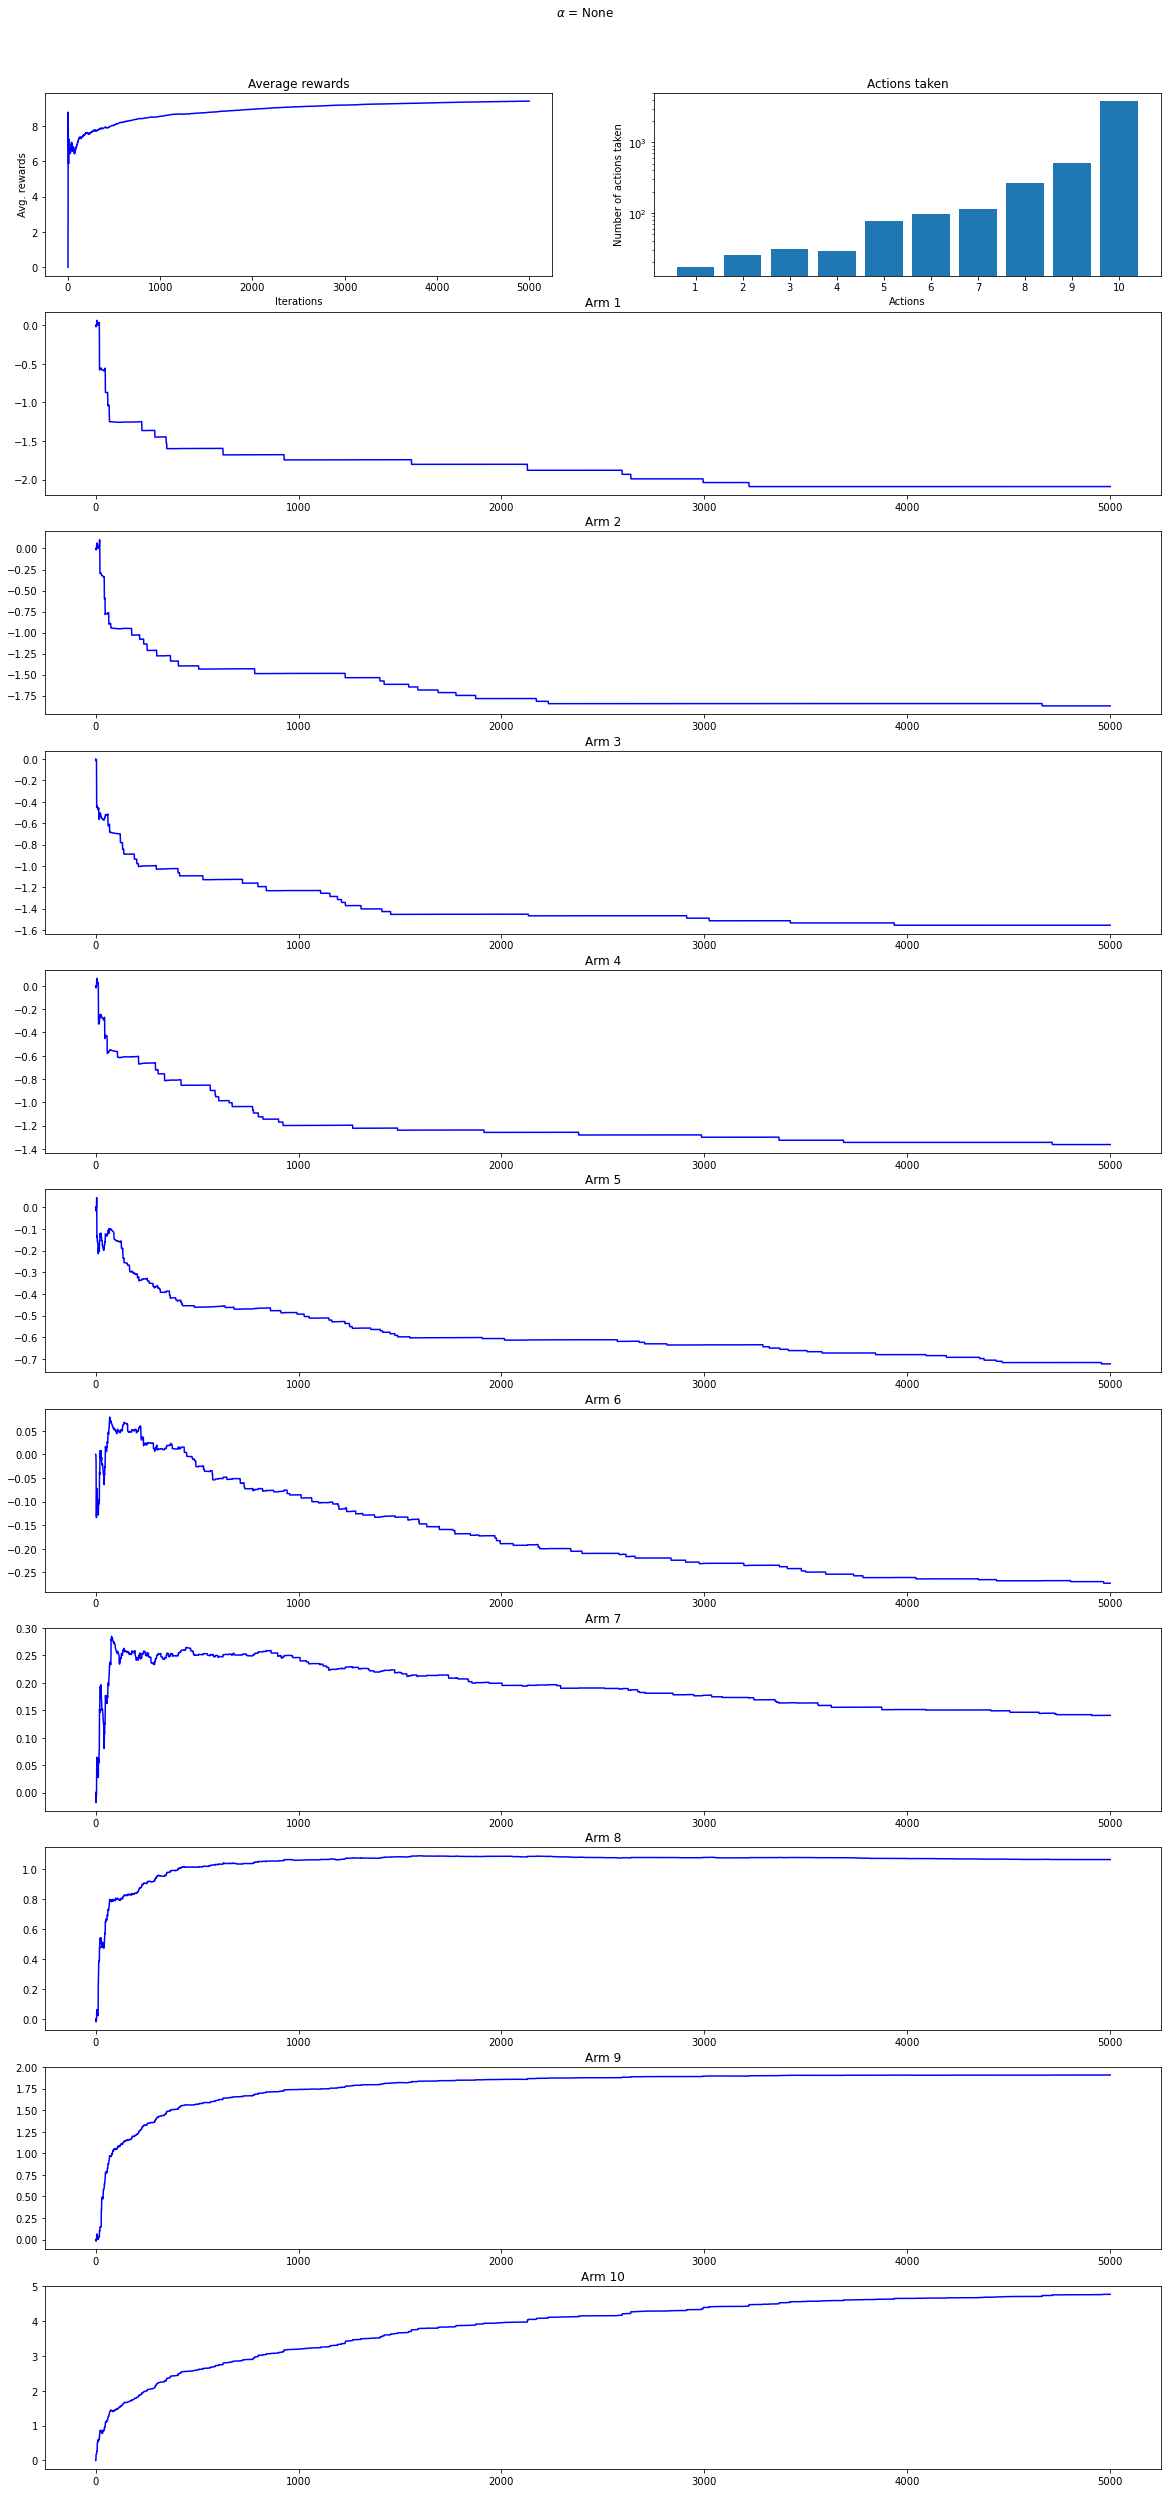

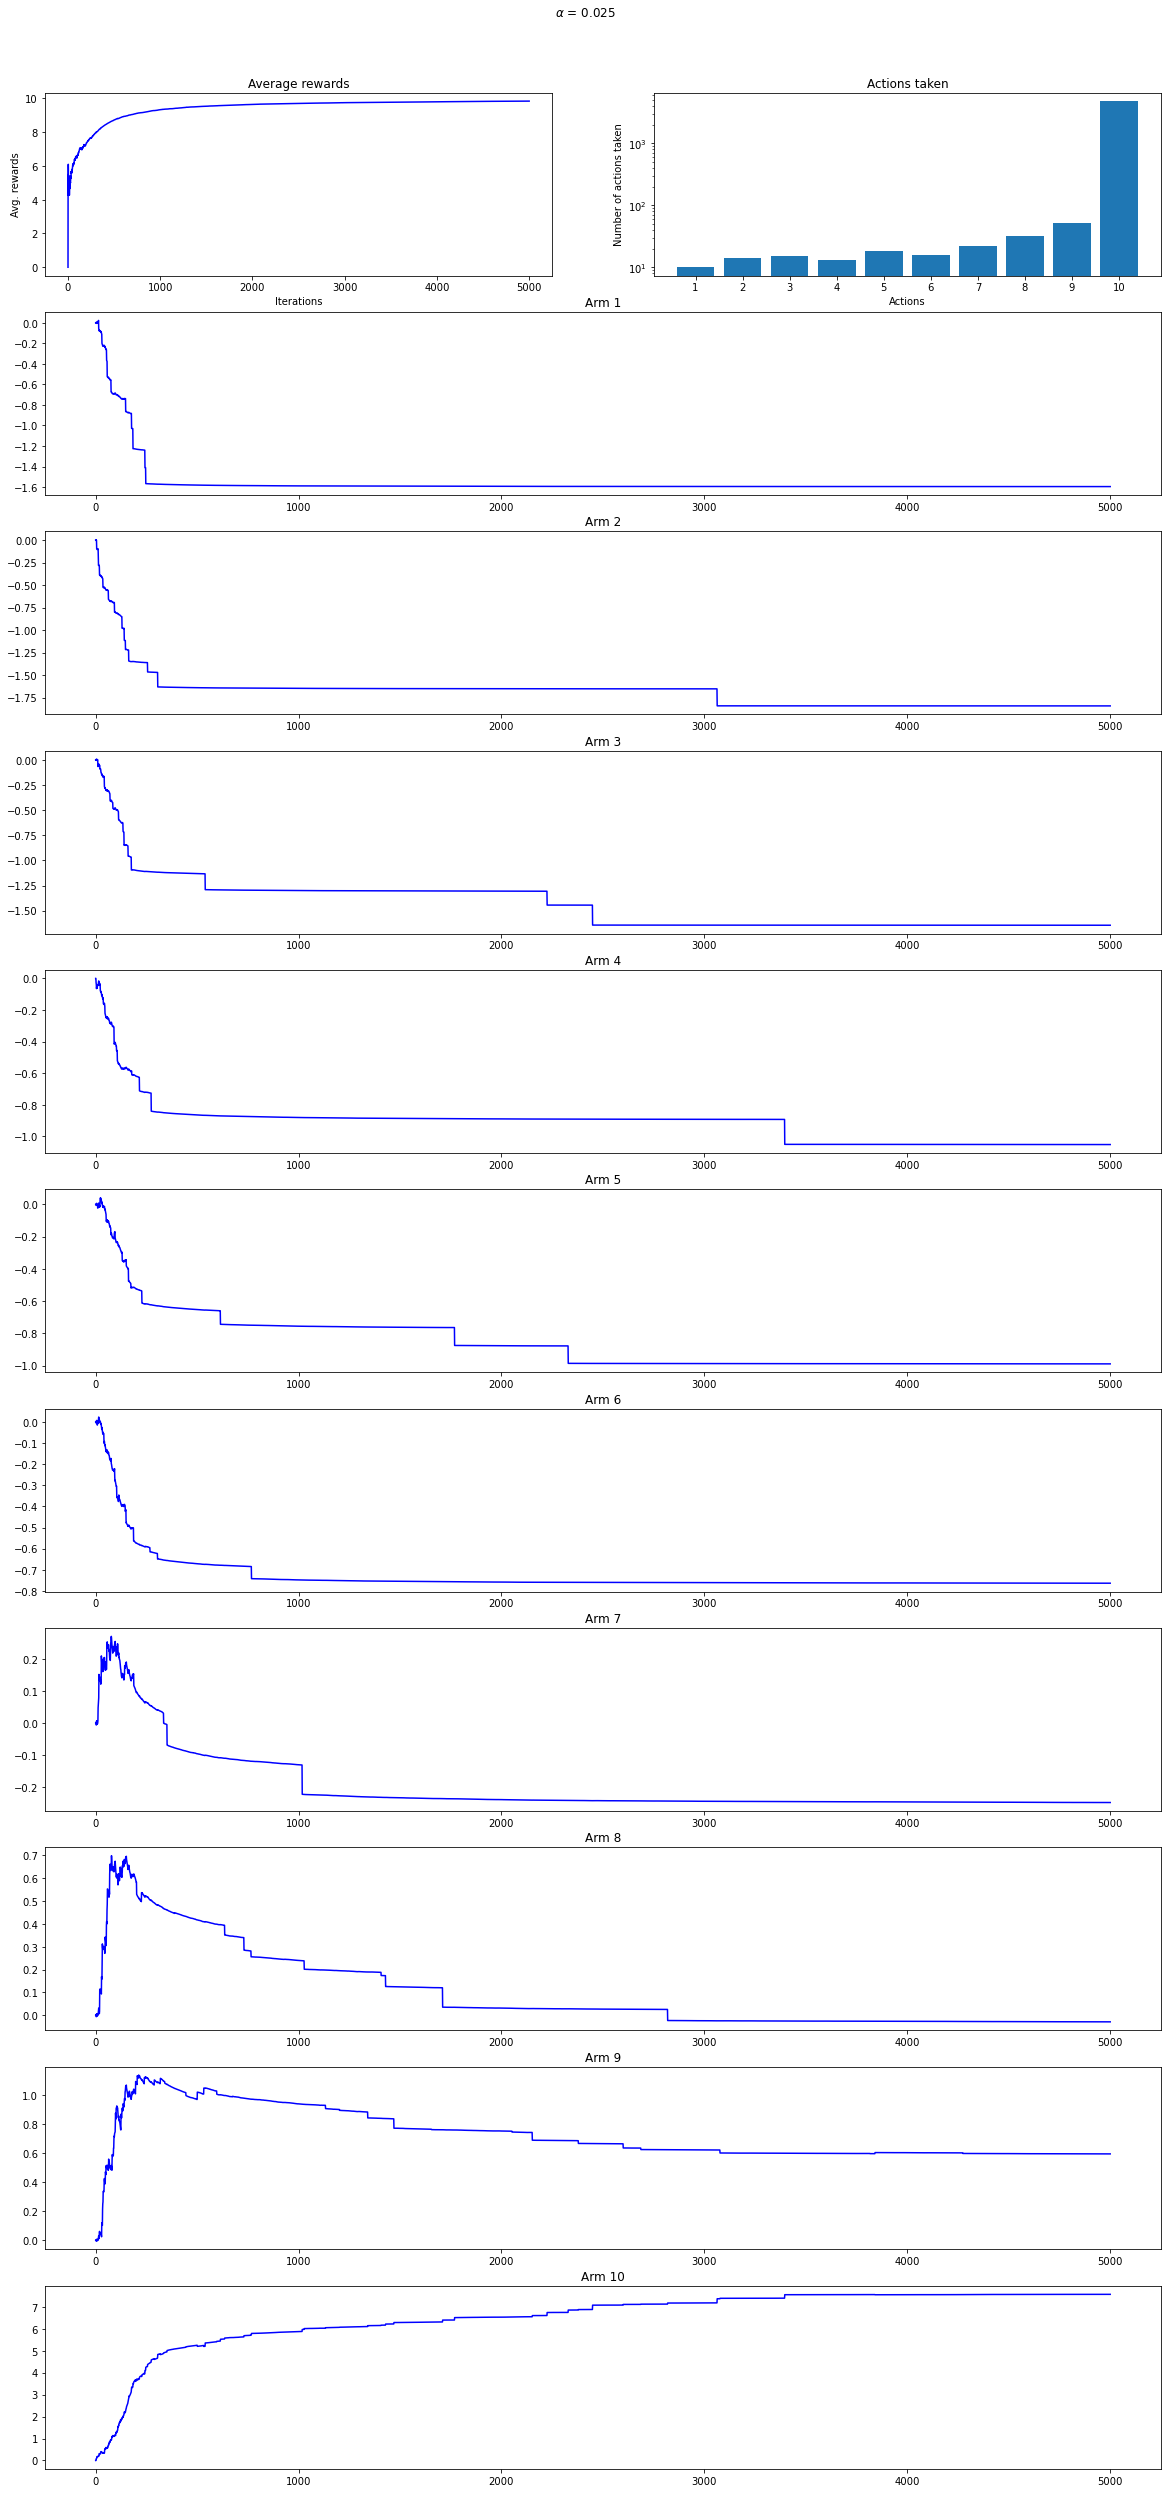

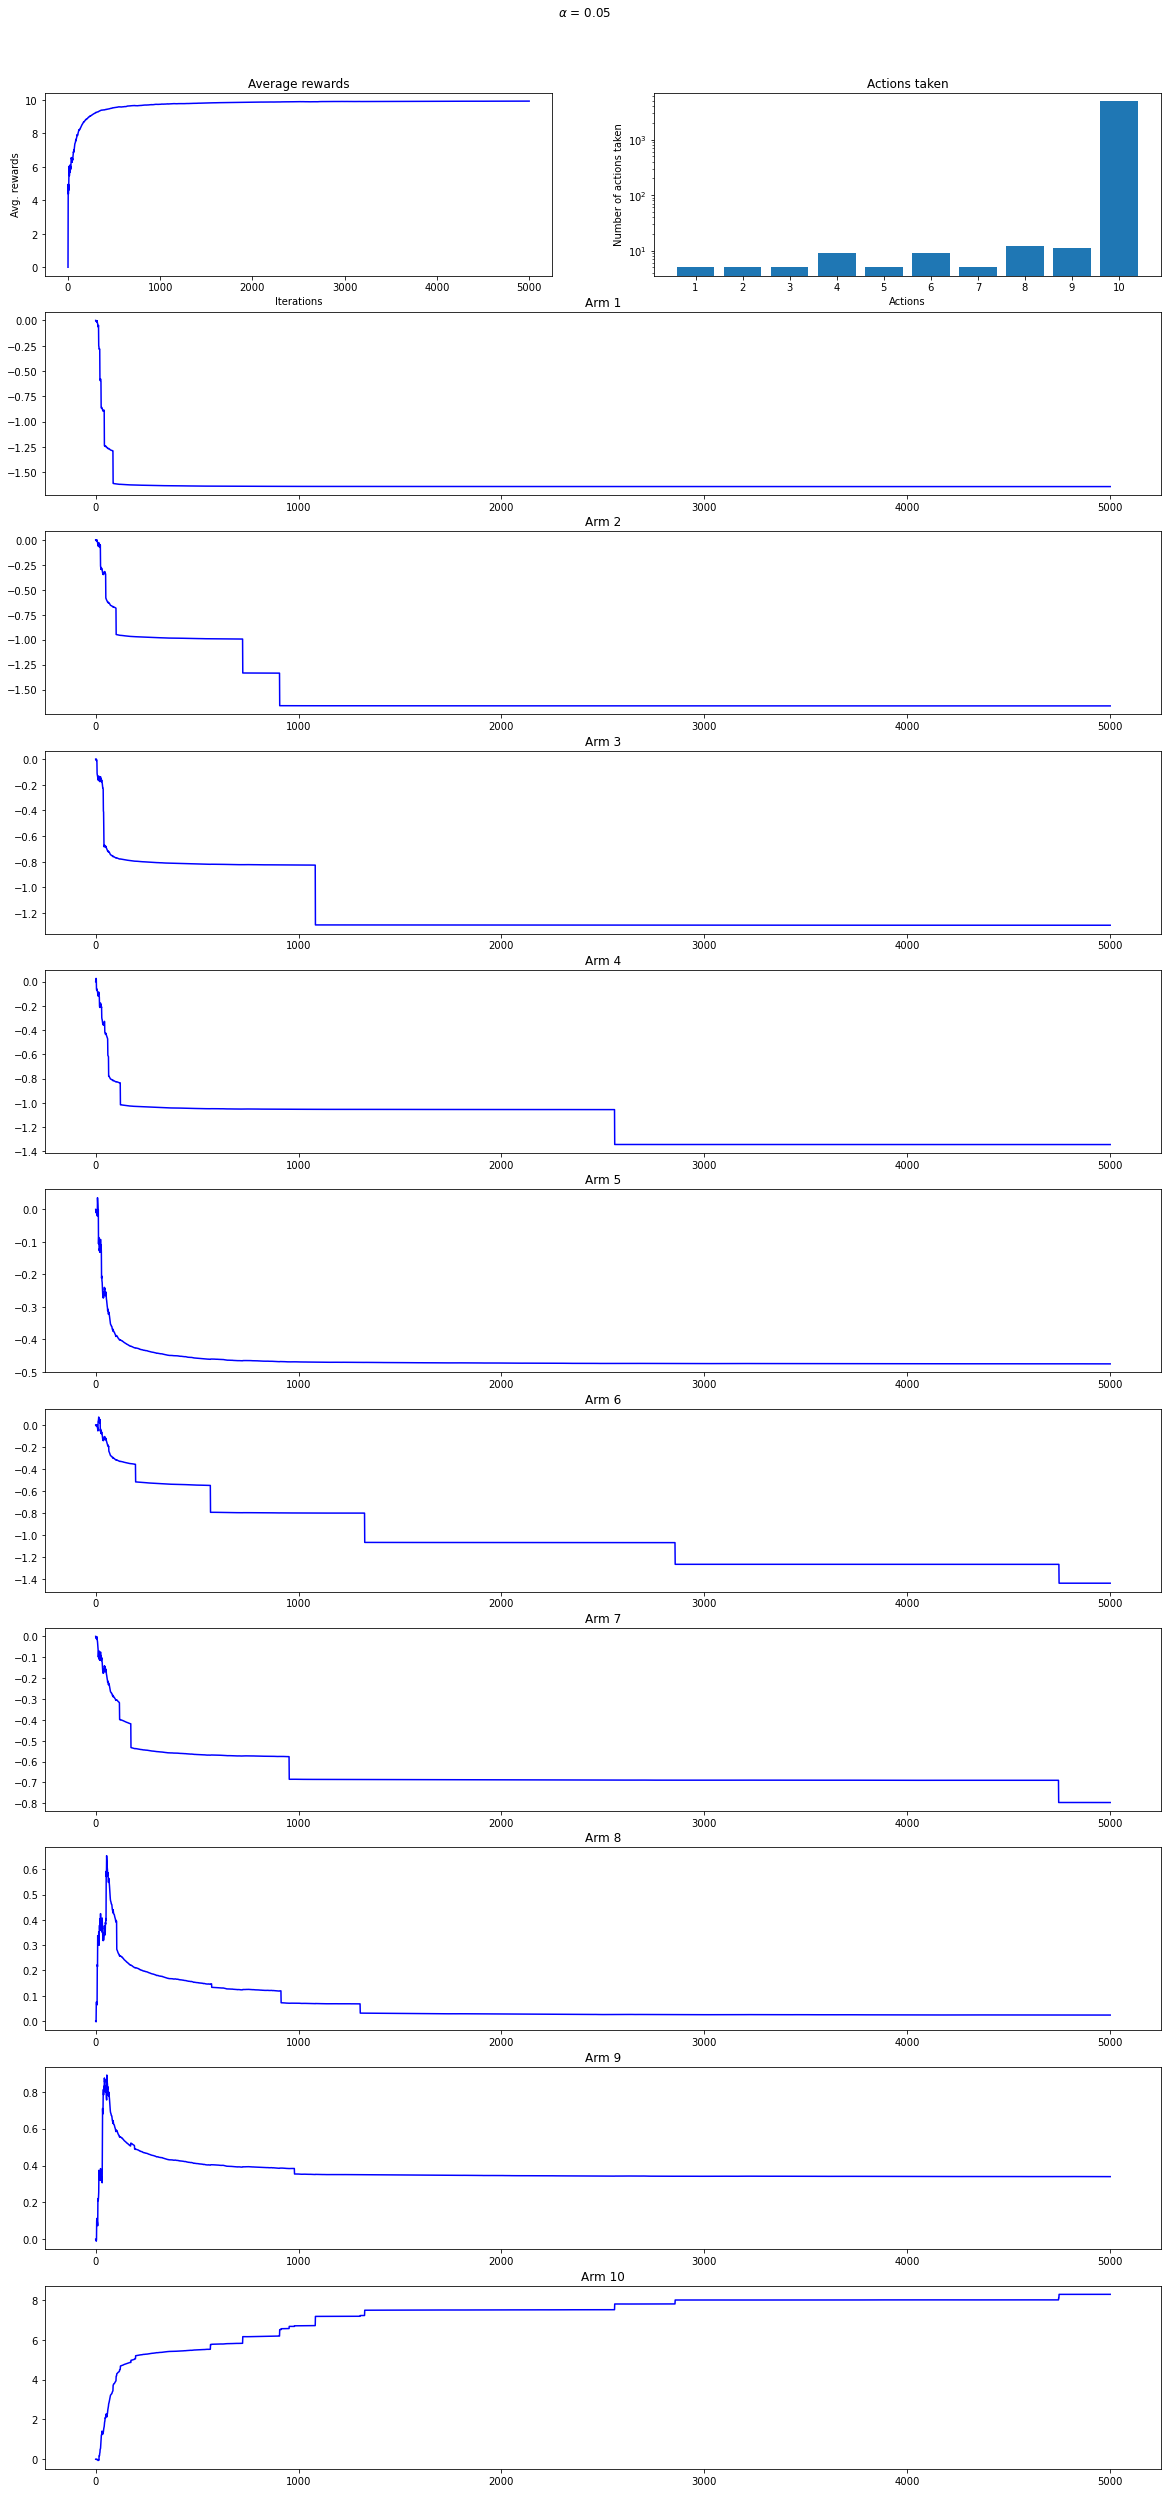

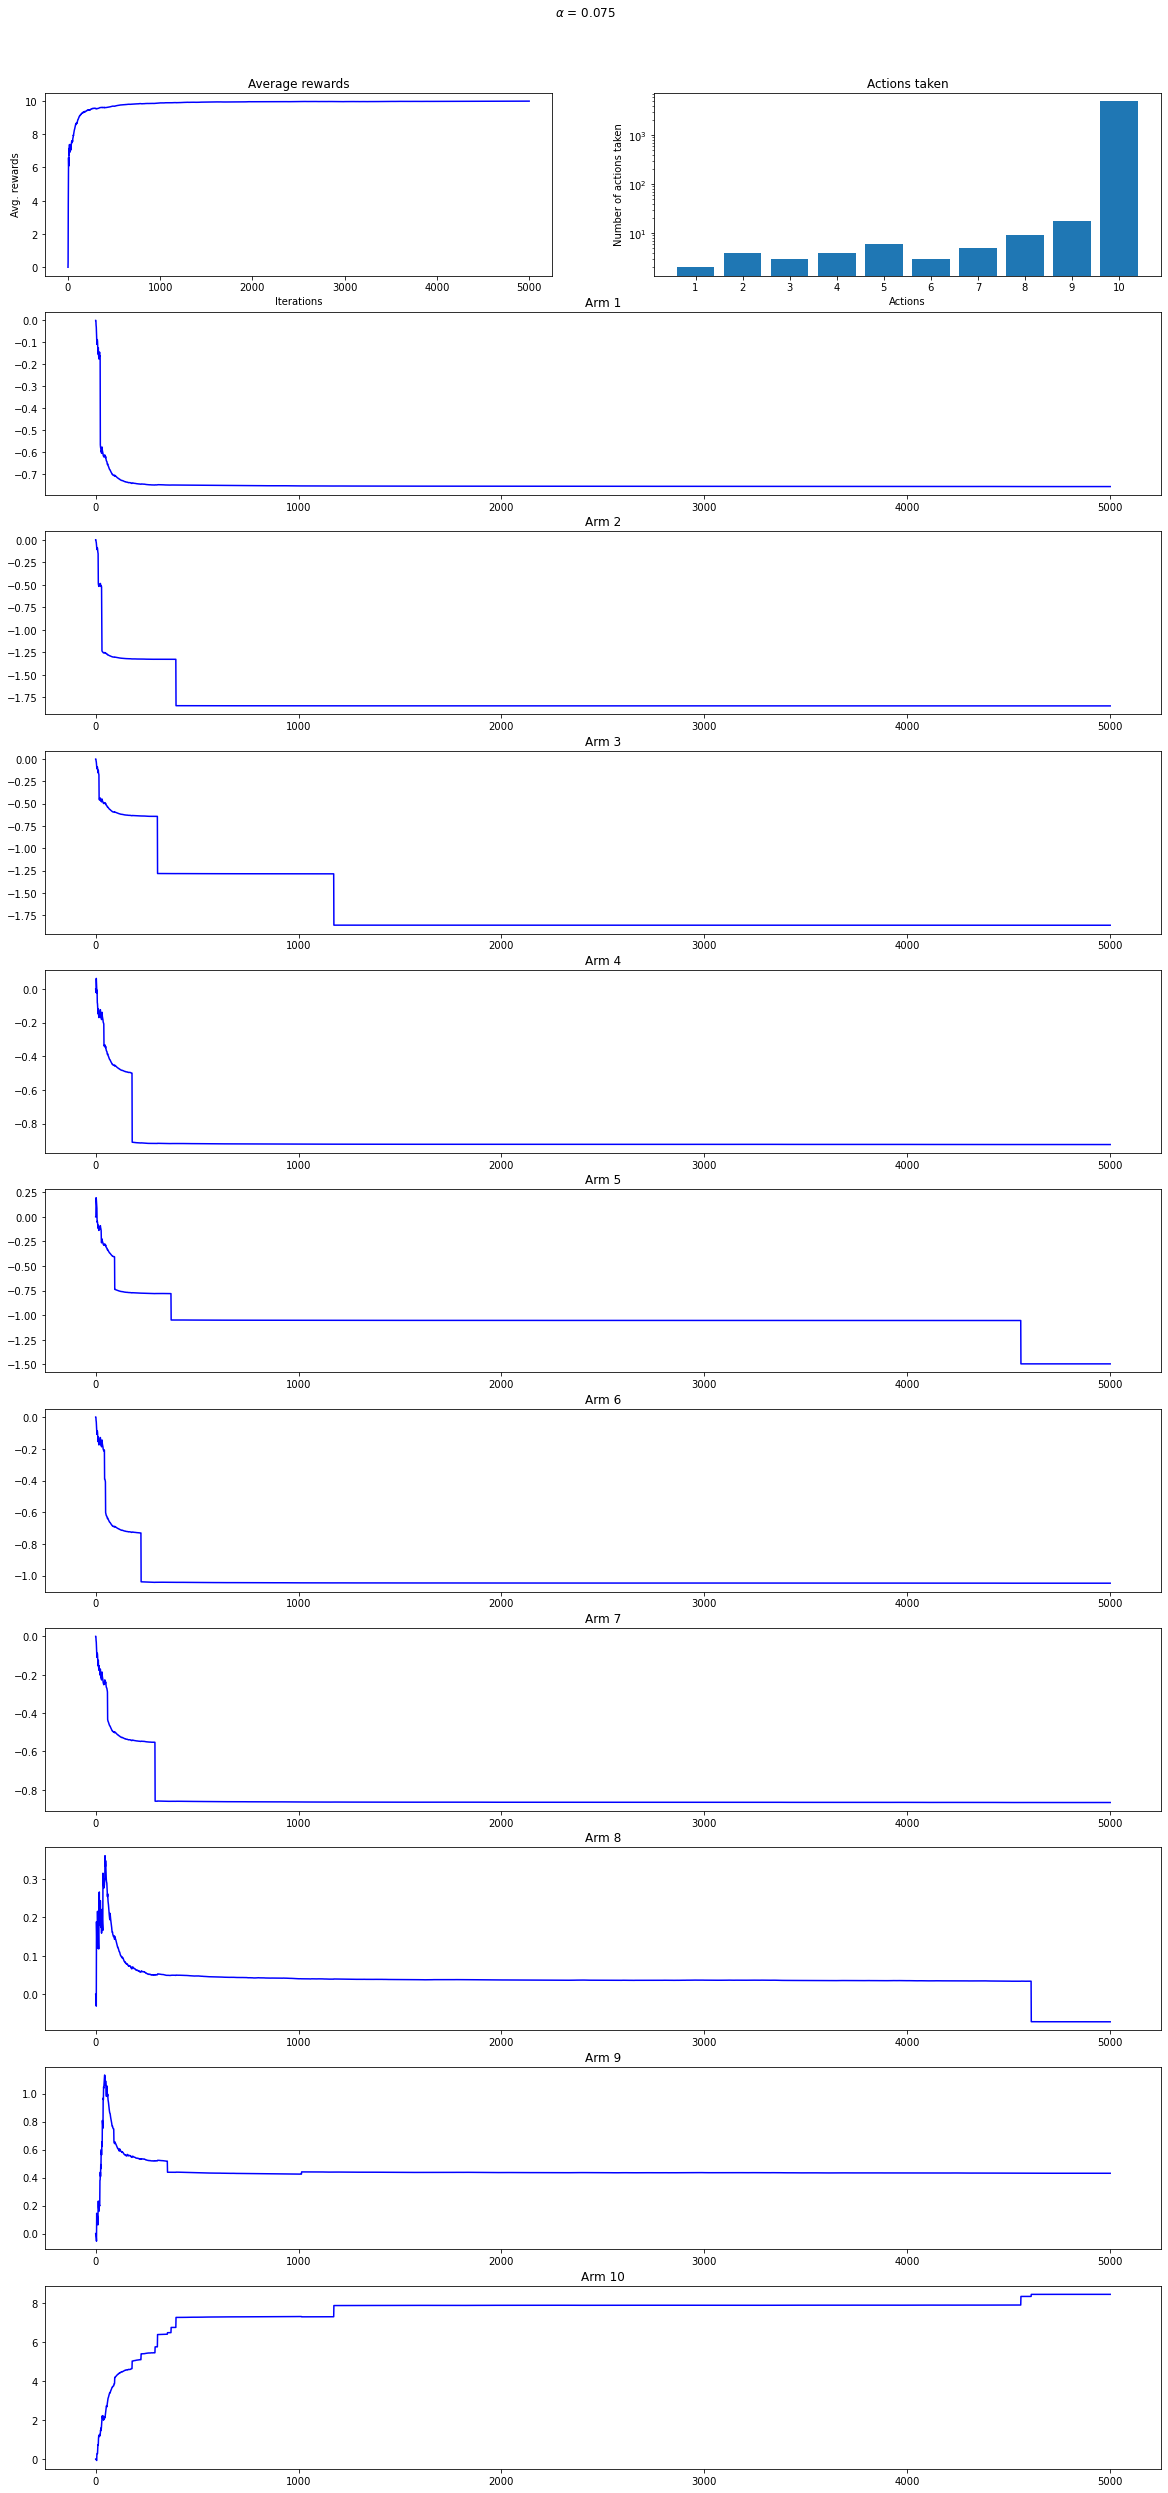

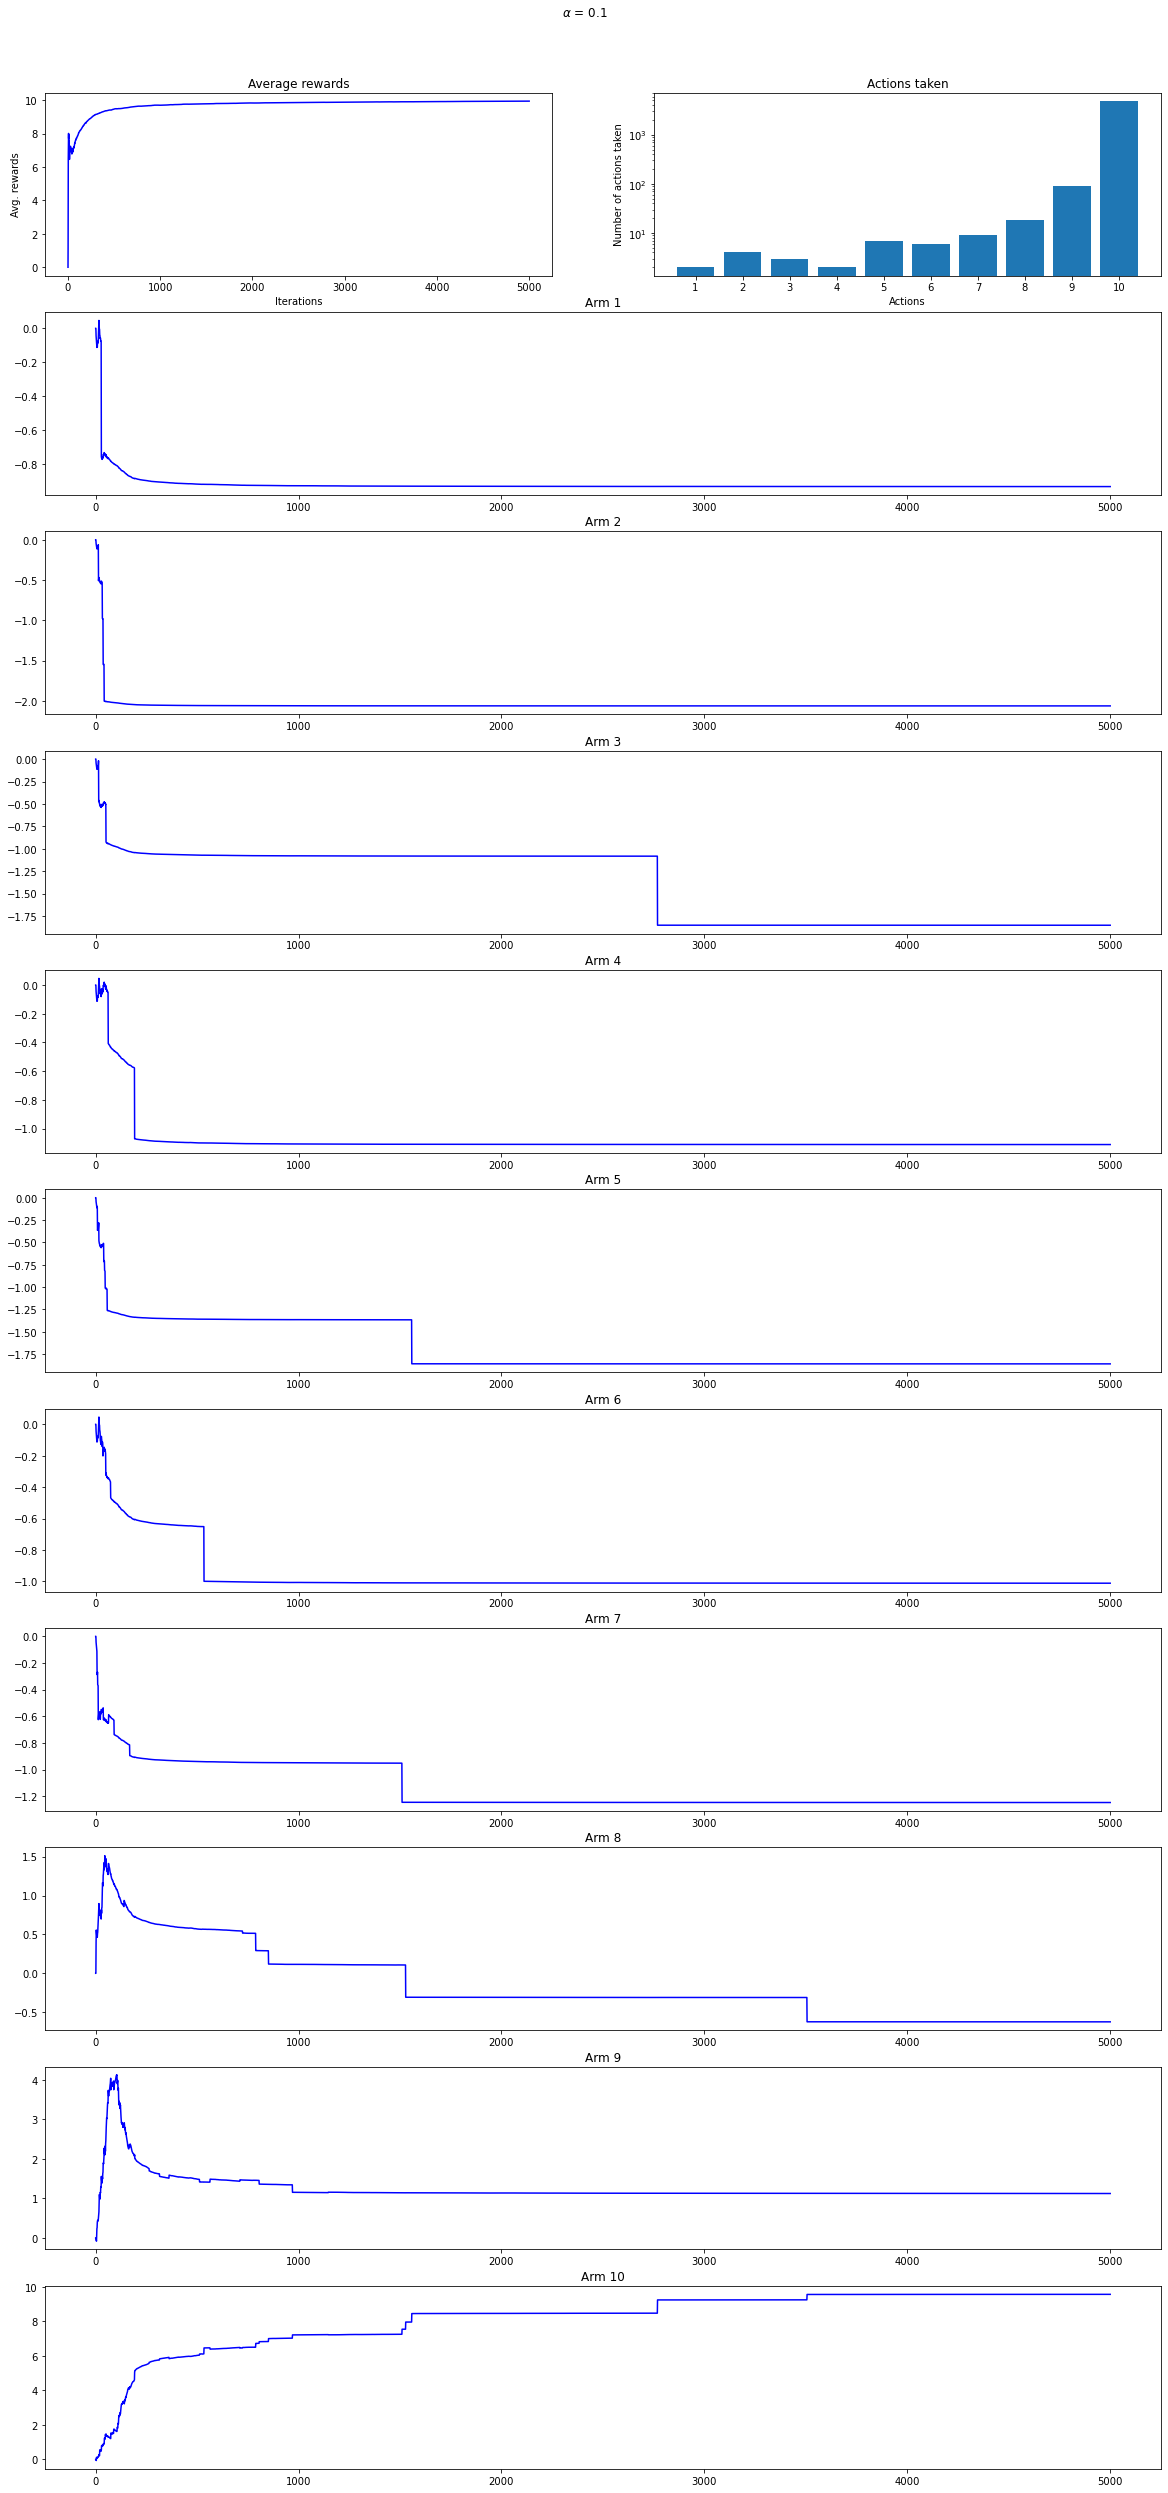

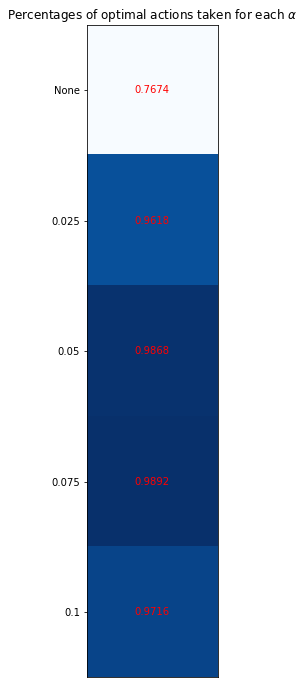

In [5]:
# Simulation parameters (some MUST be floats!).
iters = 5000
arms = 10
means = np.arange(1.0, float(arms + 1), 1.0)
sigmas = np.full(arms, 1.0)
alphas = [None, 0.025, 0.05, 0.075, 0.1]
det = False
stat = True

pref_plots(iters, arms, means, sigmas, alphas, det, stat)

## Stochastic, non-stationary case

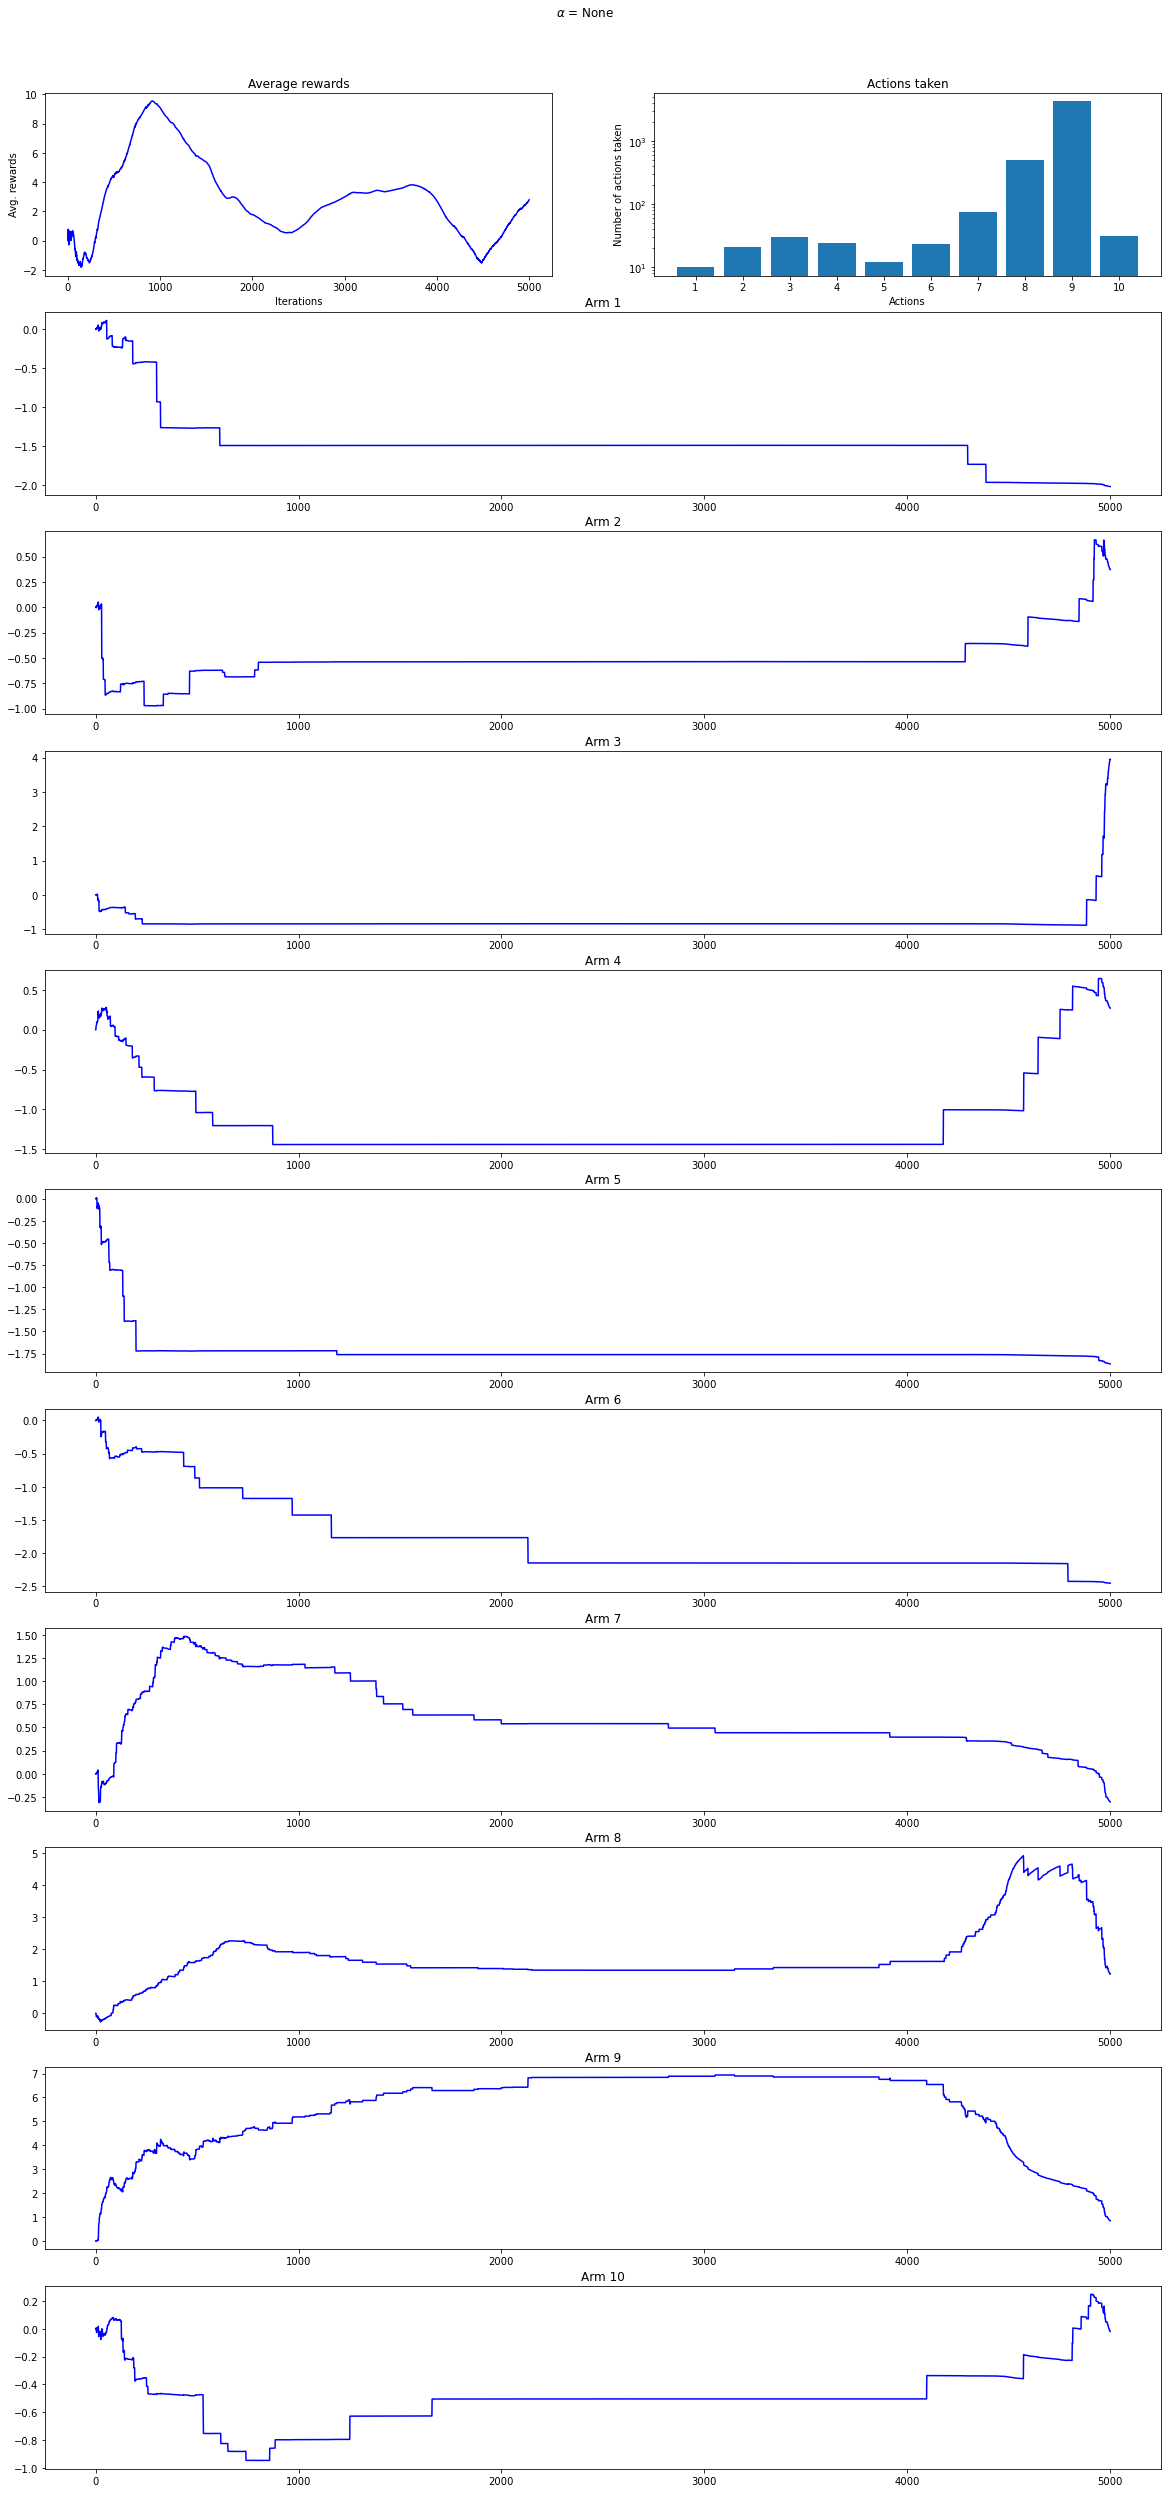

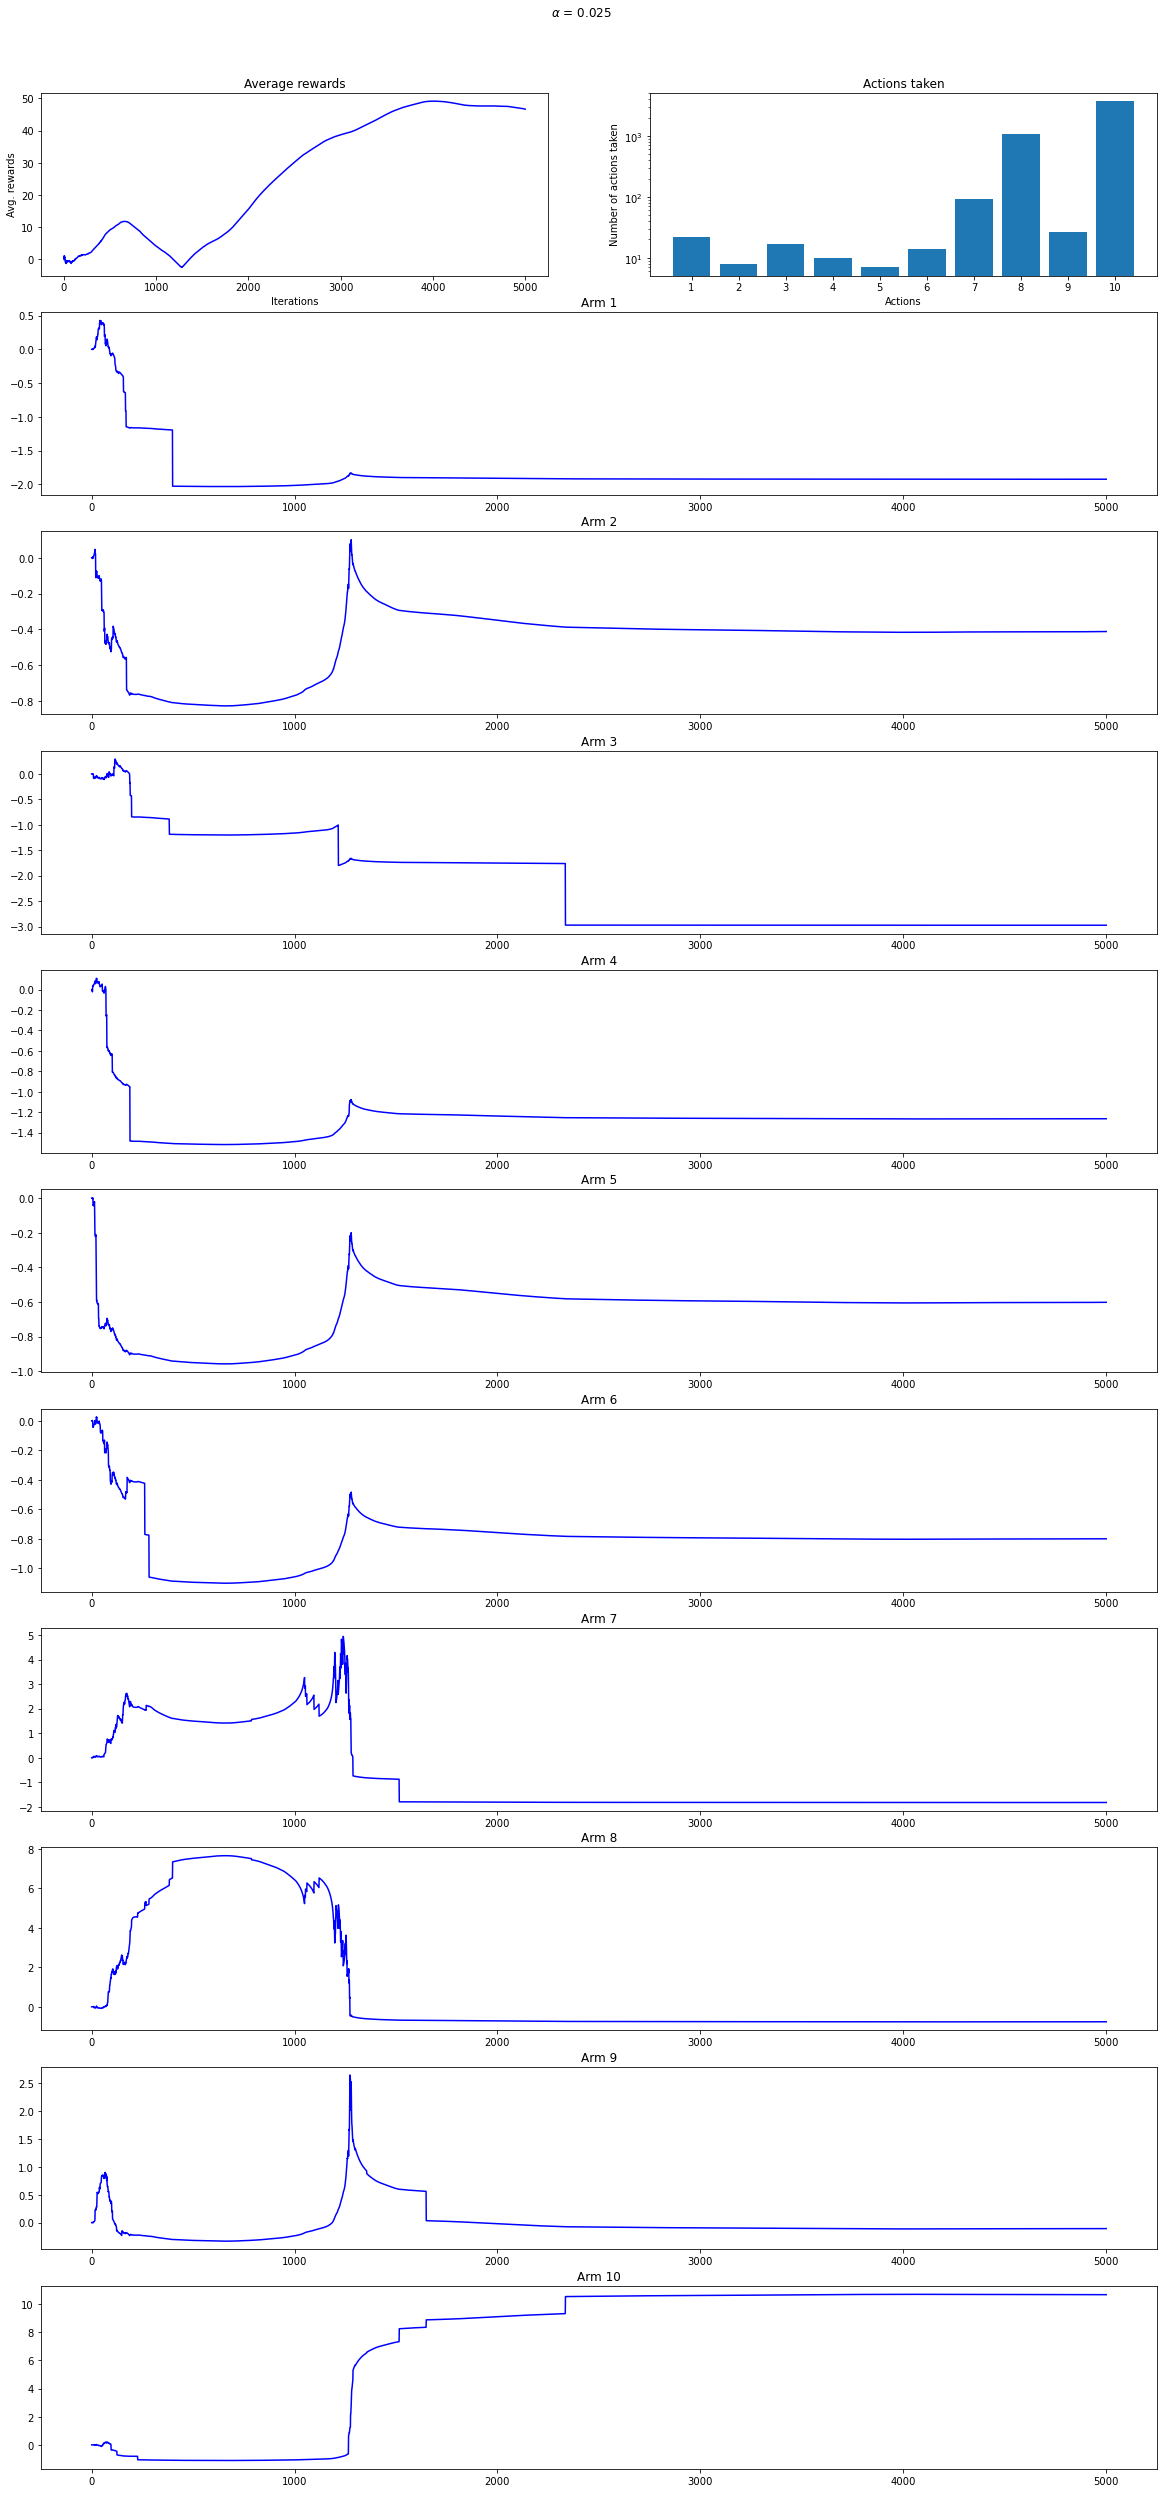

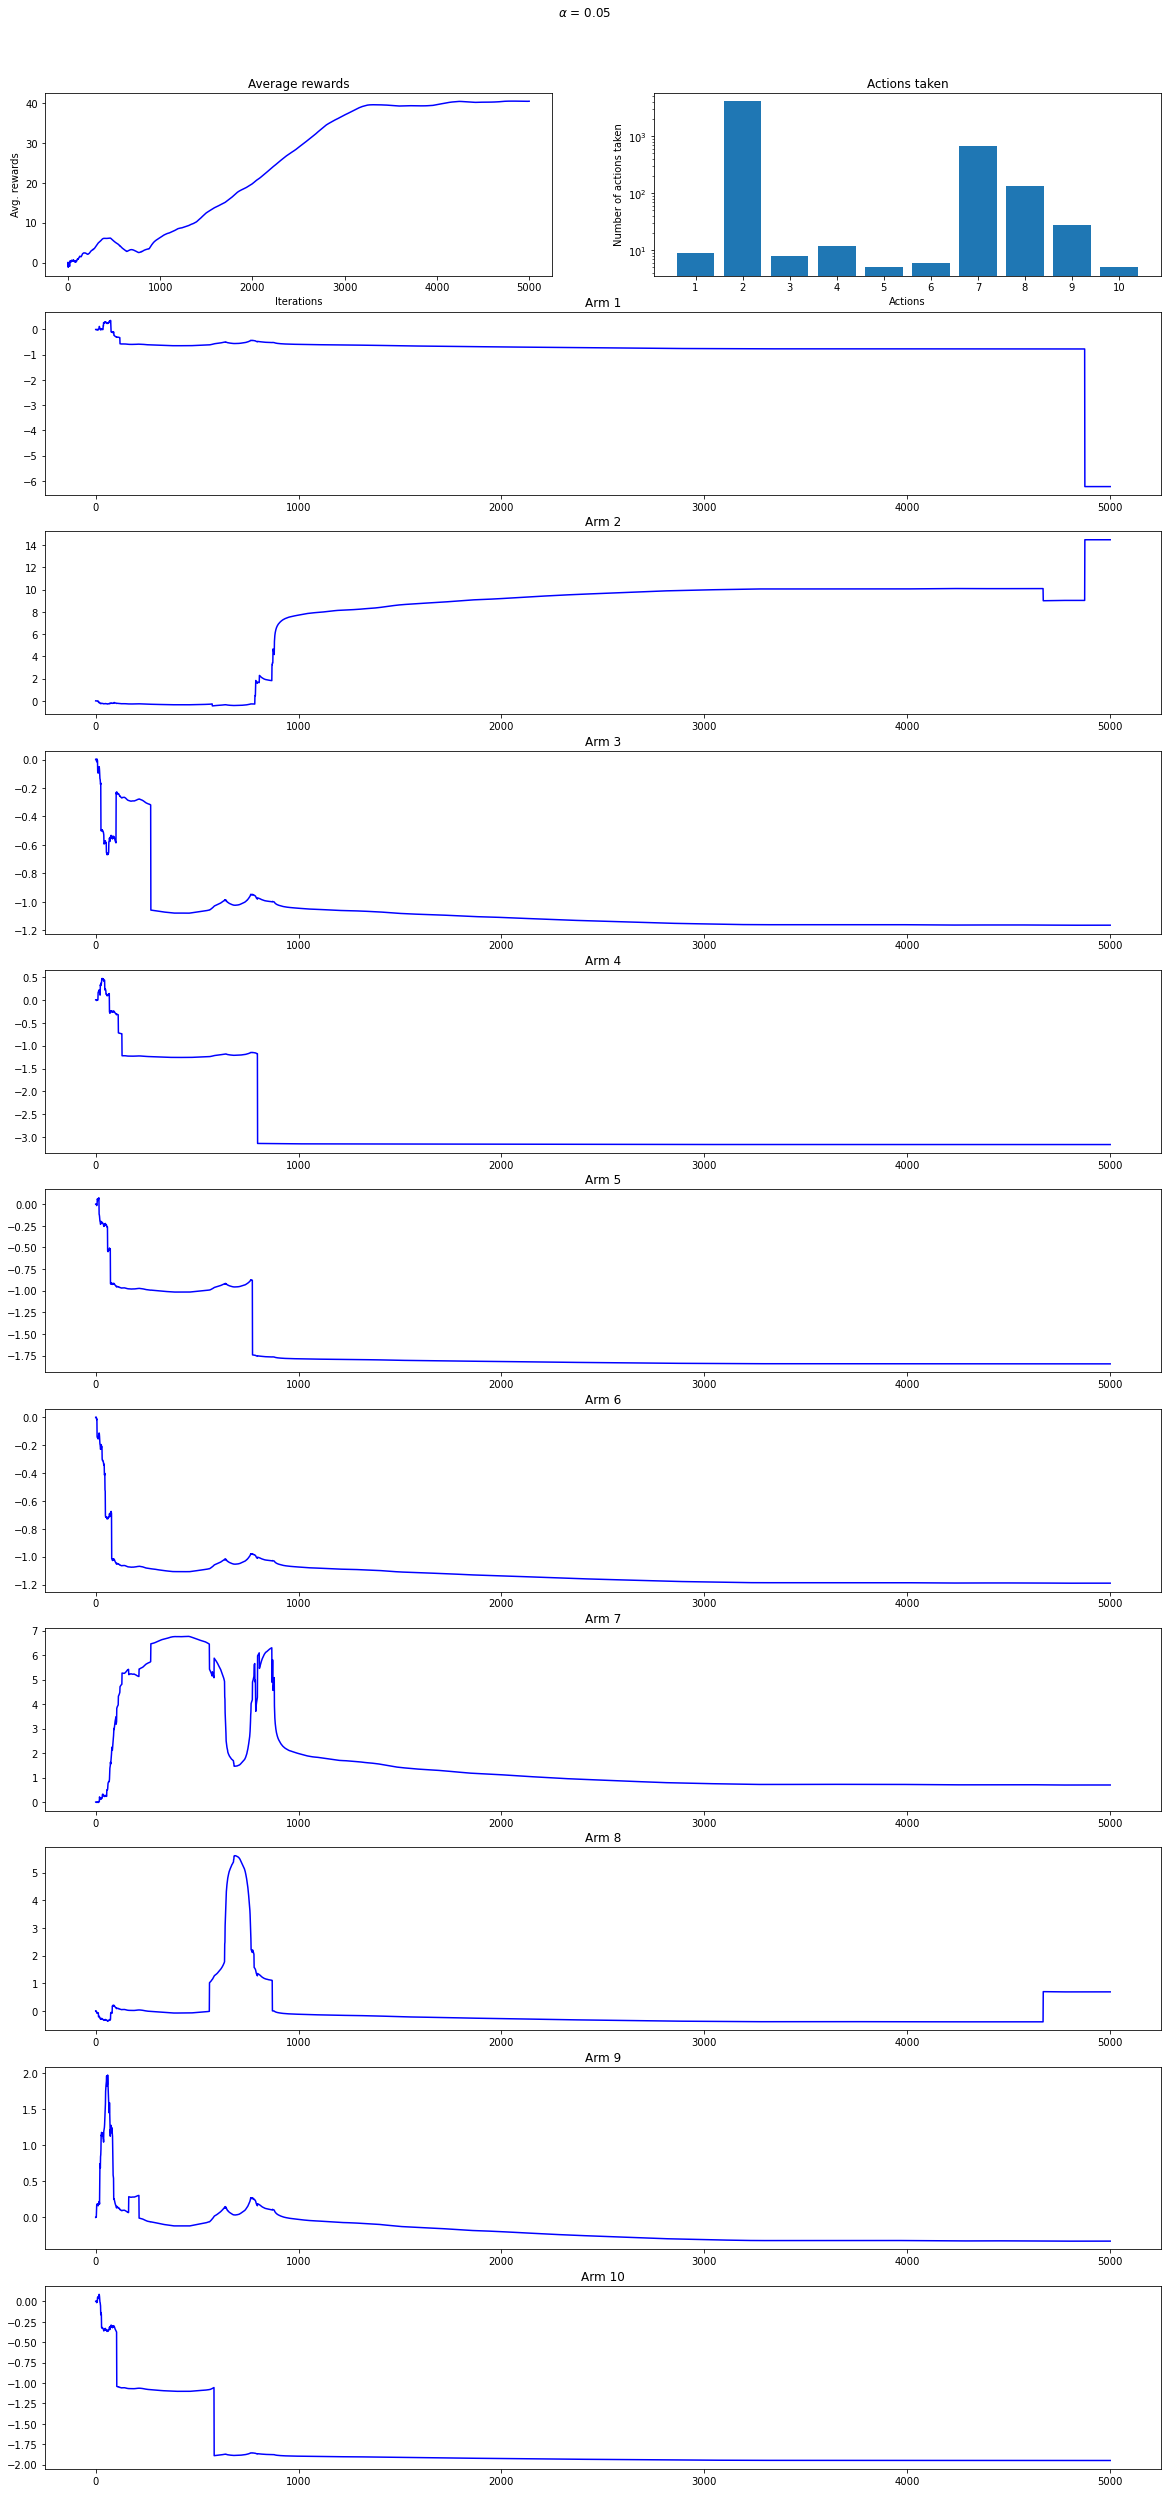

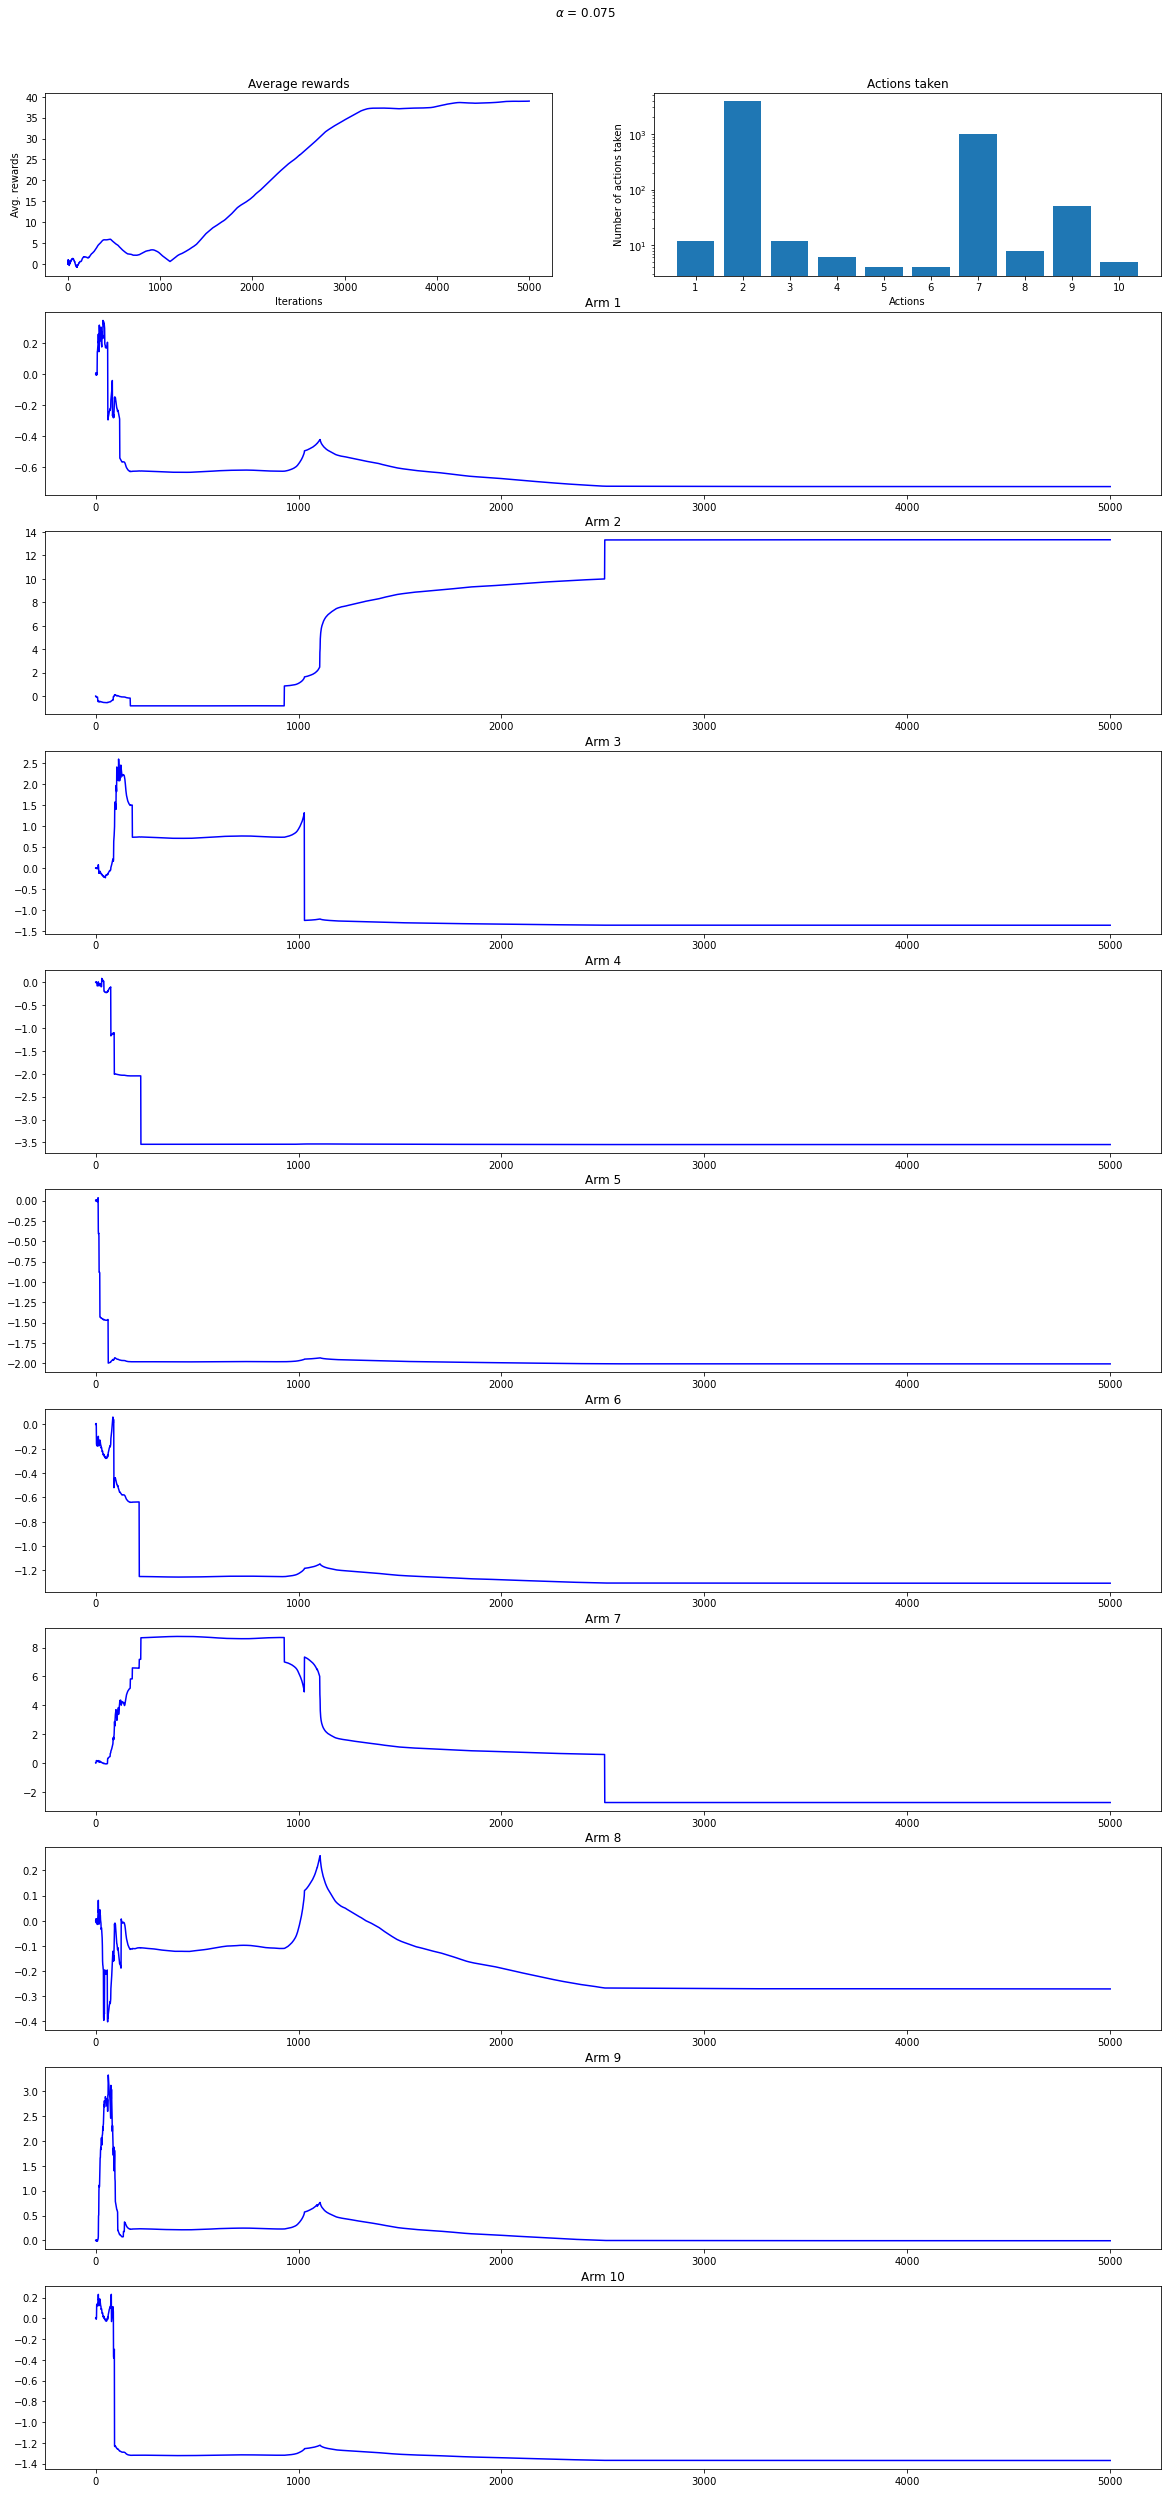

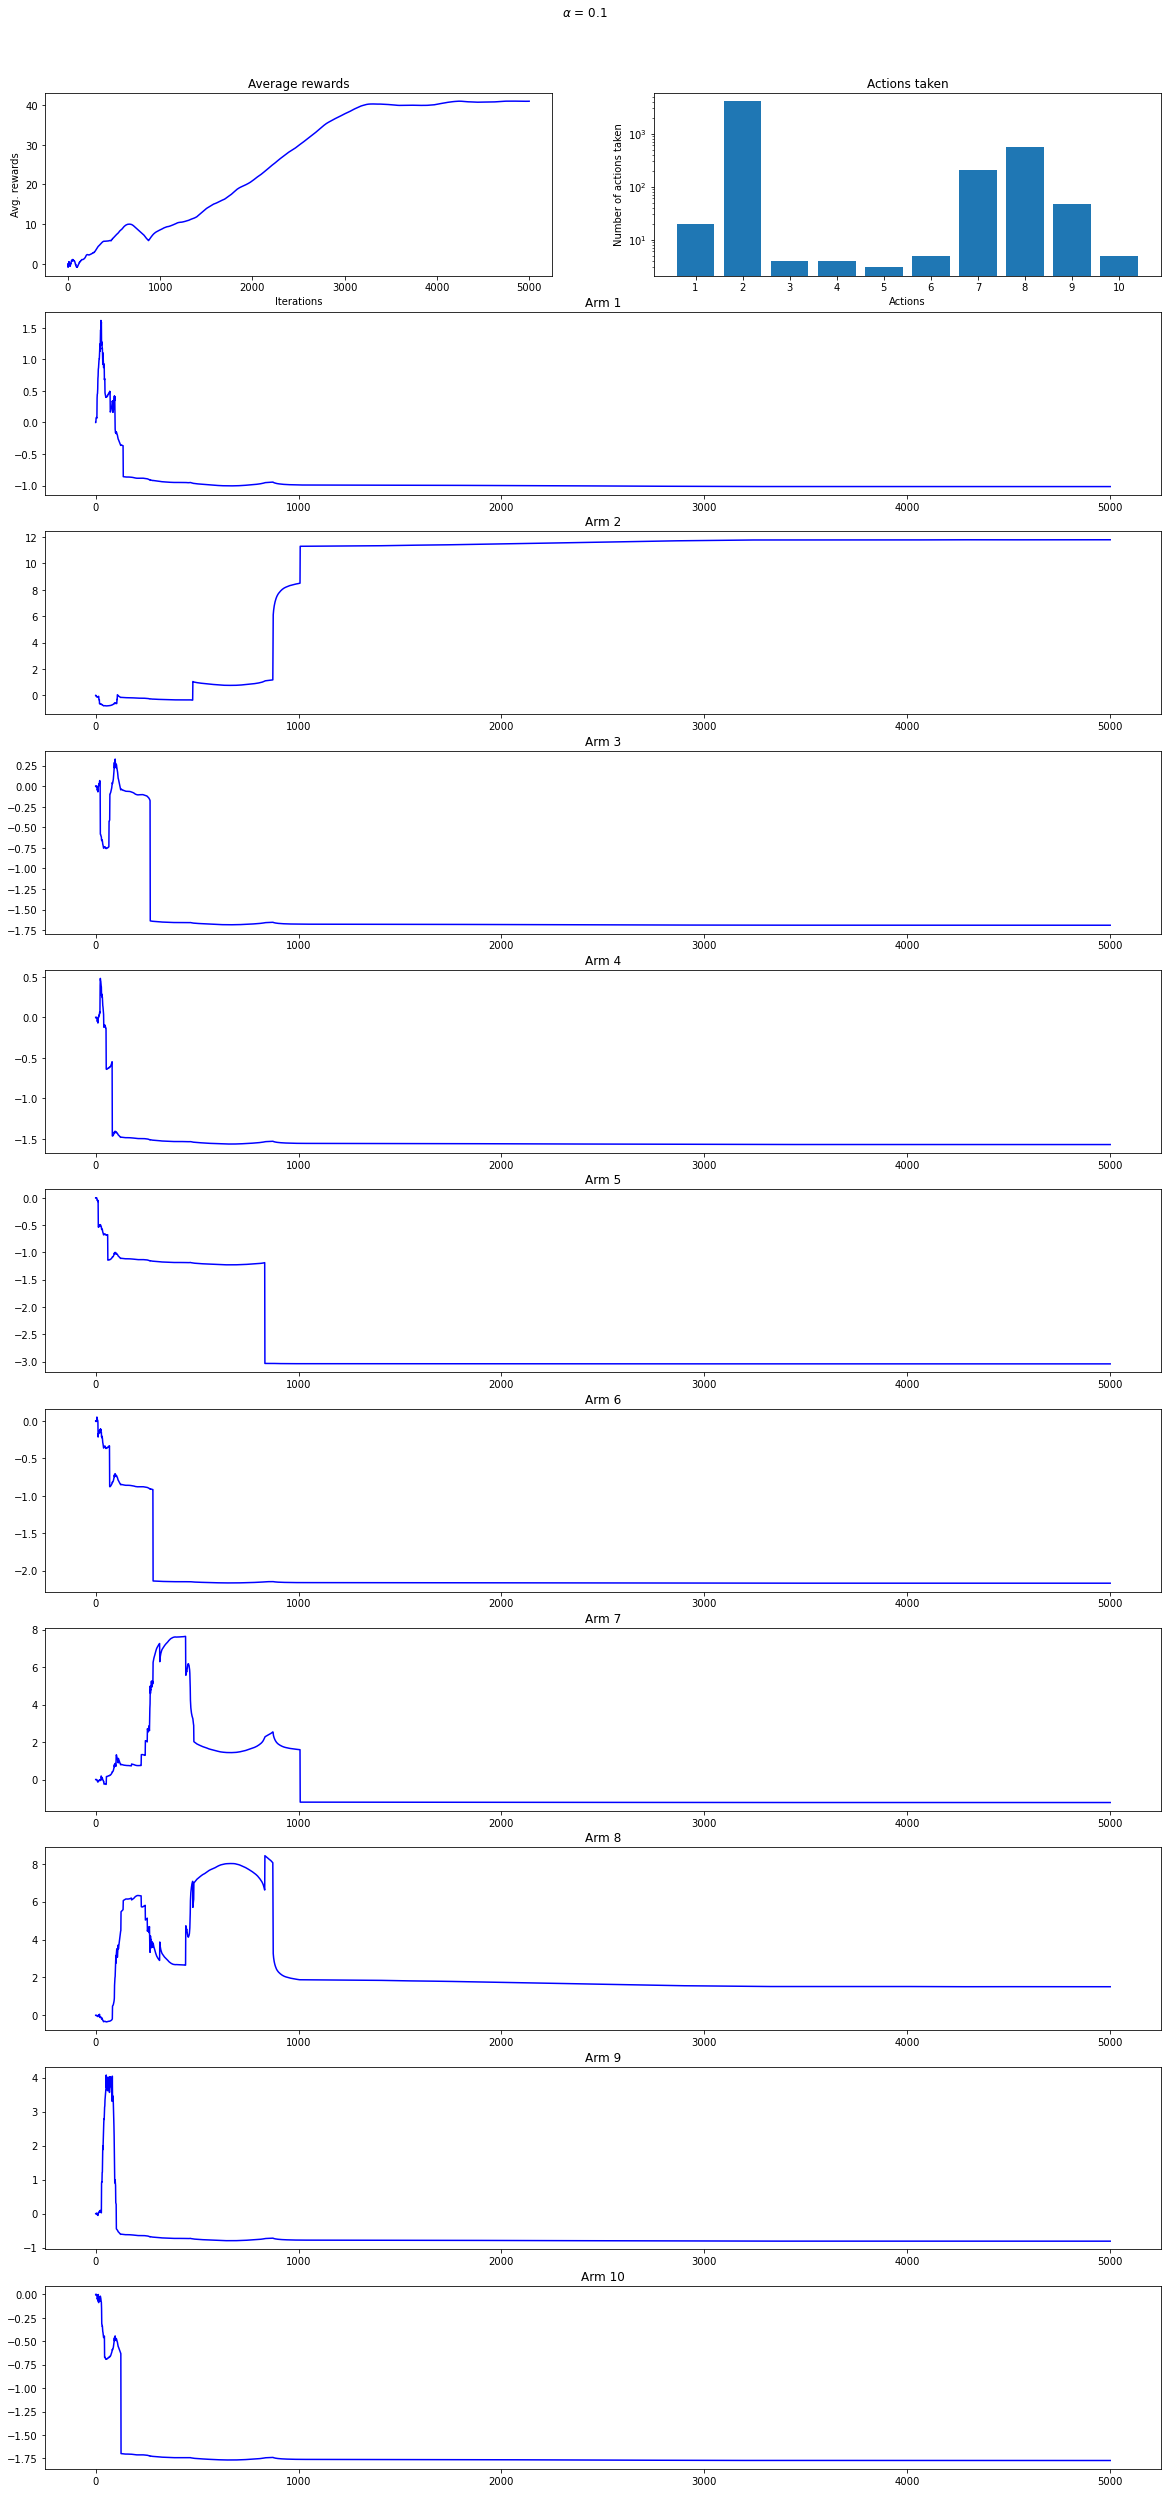

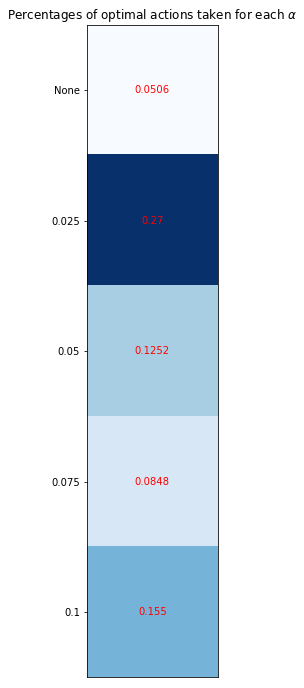

In [6]:
# Simulation parameters (some MUST be floats!).
iters = 5000
arms = 10
means = np.full(arms, 0.0)
sigmas = np.full(arms, 1.0)
alphas = [None, 0.025, 0.05, 0.075, 0.1]
det = False
stat = False

pref_plots(iters, arms, means, sigmas, alphas, det, stat)